In [34]:
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install scipy
!pip install ctgan

In [ ]:
# Let's read the CSV file into a pandas DataFrame using the given local file path.
import pandas as pd

# Path to the CSV file
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Read the CSV file into a DataFrame
combined_df = pd.read_csv(file_path)

# Show the first few rows of the DataFrame
combined_df.head()


Datetime       Code         Activity_Type  \
0  2022=12-08 14:17        NaN  No Physical Activity   
1  2022=12-08 21:05  LA11836-6               Running   
2  2022=12-08 22:01  LA11836-6               Running   
3  2022=12-08 22:06  LA11836-6               Running   
4  2022=12-08 22:16        NaN  No Physical Activity   

   Heart rate___beats/minute  Calories burned_kcal  Exercise duration_s  \
0                       72.0                   NaN                  NaN   
1                      156.0                  20.0              40851.0   
2                      170.0                  30.0              44878.0   
3                      166.0                  20.0              21497.0   
4                       78.0                   NaN                  NaN   

   Sleep type duration_minutes  Sleep duration_minutes  \
0                          NaN                     NaN   
1                          NaN                     NaN   
2                          NaN                     NaN   
3                          NaN                     NaN   
4                          NaN                     NaN   

   Floors climbed___floors Patient ID  
0                      NaN      User0  
1                      NaN      User0  
2                      NaN      User0  
3                      NaN      User0  
4                      NaN      User0

         Light Sleep No Physical Activity           Running    Floors Climbed  \
0   [17.94%, 12.62%]       [0.65%, 1.76%]  [60.99%, 24.78%]  [16.96%, 17.49%]   
1   [36.80%, 11.68%]       [3.98%, 4.05%]   [12.20%, 6.20%]  [29.88%, 19.06%]   
2   [53.90%, 13.06%]      [10.57%, 8.84%]    [8.09%, 5.39%]   [11.83%, 9.04%]   
3    [47.42%, 7.94%]       [8.50%, 6.57%]    [3.67%, 2.81%]    [8.79%, 5.12%]   
4   [30.33%, 11.47%]     [36.86%, 13.41%]    [6.75%, 5.74%]   [14.46%, 8.23%]   
5   [24.37%, 12.48%]     [45.62%, 11.22%]   [17.99%, 7.47%]    [7.54%, 6.06%]   
6   [26.92%, 10.11%]     [44.52%, 12.03%]   [17.60%, 8.69%]    [7.47%, 7.29%]   
7   [32.49%, 11.83%]     [33.10%, 13.63%]  [19.78%, 11.61%]   [11.44%, 9.38%]   
8   [27.87%, 12.82%]     [25.21%, 11.58%]  [18.48%, 11.92%]  [25.75%, 13.27%]   
9   [24.78%, 11.18%]     [20.51%, 11.18%]   [13.59%, 9.00%]  [37.63%, 12.15%]   
10  [24.29%, 12.58%]     [24.58%, 13.68%]   [10.99%, 7.77%]  [36.30%, 14.36%]   
11  [28.32%, 13.75%]     [31

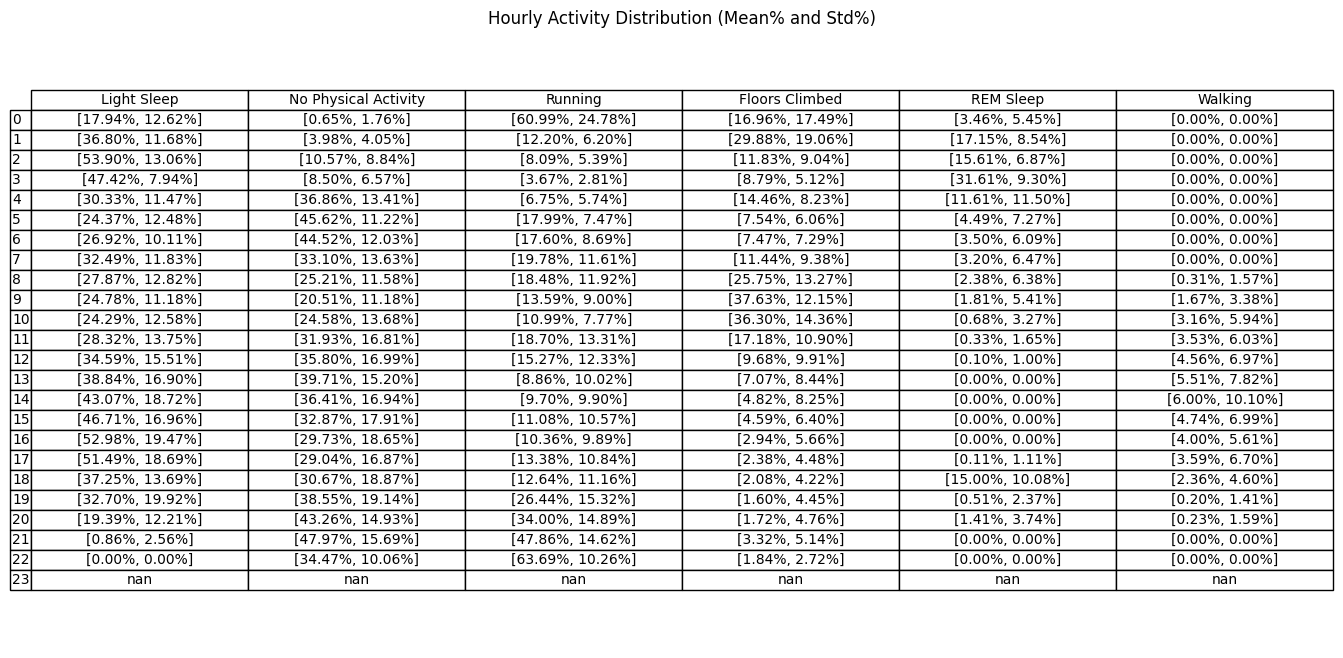

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'].str.replace('=', '-', regex=False), errors='coerce')

# Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define activities of interest
activities = ['Light Sleep', 'No Physical Activity', 'Running', 'Floors Climbed', 'REM Sleep', 'Walking']

# Group by patient, hour, and activity type, count the occurrences, and calculate the percentages
grouped = combined_df.groupby(['Patient ID', 'Hour', 'Activity_Type']).size().unstack(fill_value=0)
percentages = grouped.div(grouped.sum(axis=1), axis=0).fillna(0) * 100

# Initialize a DataFrame to store the results
results = pd.DataFrame(index=range(24), columns=activities)

# Calculate mean and standard deviation for each hour and activity
for hour in range(24):
    if hour in percentages.index.get_level_values('Hour'):
        hourly_data = percentages.xs(hour, level='Hour').fillna(0)
        mean_values = hourly_data.mean()
        std_values = hourly_data.std()

        for activity in activities:
            mean_std_format = f"[{mean_values.get(activity, 0):.2f}%, {std_values.get(activity, 0):.2f}%]"
            results.at[hour, activity] = mean_std_format

# Display the results
print(results)

# Save the table as a PNG file
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results.values, colLabels=results.columns, rowLabels=results.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Hourly Activity Distribution (Mean% and Std%)')

# Save as PNG
plt.savefig('hourly_activity_distribution.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

print("Table saved as 'hourly_activity_distribution.png'.")


In [ ]:
# Import necessary libraries
import pandas as pd
from ctgan import CTGAN
import numpy as np

# Load the real dataset (combined_df should already exist from previous steps)

# Define the mapping dictionary for activity types
activity_mapping = {
    'Light Sleep': 1,
    'No Physical Activity': 2,
    'Running': 3,
    'Floors Climbed': 4,
    'REM Sleep': 5,
    'Walking': 6
}

# Replace the 'Activity_Type' values based on the mapping dictionary
combined_df['Activity_Type'] = combined_df['Activity_Type'].replace(activity_mapping)

# Retain Activity_Type in the filtered data
df_1_5 = combined_df[combined_df['Activity_Type'].isin([1, 5])][[
    'Activity_Type', 'Heart rate___beats/minute', 'Sleep type duration_minutes', 'Sleep duration_minutes'
]].dropna()

df_3_6 = combined_df[combined_df['Activity_Type'].isin([3, 6])][[
    'Activity_Type', 'Heart rate___beats/minute', 'Calories burned_kcal', 'Exercise duration_s'
]].dropna()

df_2 = combined_df[combined_df['Activity_Type'] == 2][[
    'Activity_Type', 'Heart rate___beats/minute'
]].dropna()

df_4 = combined_df[combined_df['Activity_Type'] == 4][[
    'Activity_Type', 'Heart rate___beats/minute', 'Floors climbed___floors'
]].dropna()

# Helper function to train and generate synthetic data using CTGAN
def generate_synthetic_data(real_data, num_samples):
    ctgan = CTGAN()
    ctgan.fit(real_data, epochs=100)
    synthetic_data = ctgan.sample(num_samples)
    return synthetic_data

# Generate synthetic data for each subset
synthetic_df_1_5 = generate_synthetic_data(df_1_5, num_samples=100000)
synthetic_df_3_6 = generate_synthetic_data(df_3_6, num_samples=100000)
synthetic_df_2 = generate_synthetic_data(df_2, num_samples=100000)
synthetic_df_4 = generate_synthetic_data(df_4, num_samples=100000)

# Combine all the generated synthetic data
synthetic_combined_df = pd.concat([synthetic_df_1_5, synthetic_df_3_6, synthetic_df_2, synthetic_df_4], ignore_index=True)

# Convert the relevant columns to integer (keeping only the integer part)
cols_to_convert = ['Heart rate___beats/minute', 'Sleep type duration_minutes', 'Sleep duration_minutes',
                   'Calories burned_kcal', 'Exercise duration_s', 'Floors climbed___floors']

for col in cols_to_convert:
    if col in synthetic_combined_df.columns:
        synthetic_combined_df[col] = np.floor(synthetic_combined_df[col]).astype('Int64')  # Keep only integer part

# Ensure 'Floors climbed___floors' is always 1 for "Floors Climbed" activity
synthetic_combined_df.loc[synthetic_combined_df['Activity_Type'] == 'Floors Climbed', 'Floors climbed___floors'] = 1

# Reverse the mapping to convert Activity_Type back to original string values
reverse_activity_mapping = {
    1: 'Light Sleep',
    2: 'No Physical Activity',
    3: 'Running',
    4: 'Floors Climbed',
    5: 'REM Sleep',
    6: 'Walking'
}

synthetic_combined_df['Activity_Type'] = synthetic_combined_df['Activity_Type'].replace(reverse_activity_mapping)

# Define the mapping for the Code column
code_mapping = {
    'Light Sleep': '93830-8',
    'No Physical Activity': '',
    'Running': 'LA11836-6',
    'Floors Climbed': '',
    'REM Sleep': '93829-0',
    'Walking': '370'
}

# Add the Code column to the DataFrame
synthetic_combined_df['Code'] = synthetic_combined_df['Activity_Type'].map(code_mapping)

# Show the final synthetic data with original Activity_Type values and Code
print(synthetic_combined_df.head())

# Save the synthetic data to a CSV file
synthetic_combined_df.to_csv('synthetic_data_with_activity_type.csv', index=False)


<ipython-input-5-a4bbfa267399>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['Activity_Type'] = combined_df['Activity_Type'].replace(activity_mapping)


  Activity_Type  Heart rate___beats/minute  Sleep type duration_minutes  \
0   Light Sleep                         75                           15   
1   Light Sleep                         55                            6   
2   Light Sleep                         86                            8   
3   Light Sleep                         77                           11   
4     REM Sleep                         58                            4   

   Sleep duration_minutes  Calories burned_kcal  Exercise duration_s  \
0                      18                  <NA>                 <NA>   
1                      28                  <NA>                 <NA>   
2                      13                  <NA>                 <NA>   
3                      14                  <NA>                 <NA>   
4                       4                  <NA>                 <NA>   

   Floors climbed___floors     Code  
0                     <NA>  93830-8  
1                     <NA>  93830-8  
2 

In [ ]:
#generate 1 sample
import pandas as pd
import numpy as np
import random
from datetime import timedelta

def generate_synthetic_data(combined_df, start_date, end_date, num_samples):
    """
    Generate synthetic datetime and activity type data based on the original distribution.

    Parameters:
        combined_df (pd.DataFrame): Original DataFrame containing 'Datetime' and 'Activity_Type' columns.
        start_date (str or pd.Timestamp): The start date for generating synthetic datetime values.
        end_date (str or pd.Timestamp): The end date for generating synthetic datetime values.
        num_samples (int): The number of synthetic samples to generate.

    Returns:
        synthetic_df (pd.DataFrame): A DataFrame containing synthetic 'Datetime' and 'Activity_Type' columns.
    """
    # Step 1: Convert 'Datetime' to a string if it's not already in string format
    if combined_df['Datetime'].dtype != 'object':
        combined_df['Datetime'] = combined_df['Datetime'].astype(str)

    # Step 2: Replace '=' with '-' in the 'Datetime' strings
    combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

    # Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
    combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

    # Step 4: Extract hour and minute, convert to total minutes of the day
    combined_df['Hour'] = combined_df['Datetime'].dt.hour
    combined_df['Minute'] = combined_df['Datetime'].dt.minute
    combined_df['Minutes_of_Day'] = combined_df['Hour'] * 60 + combined_df['Minute']

    # Step 5: Learn the distribution of 'Minutes_of_Day'
    minutes_distribution = combined_df['Minutes_of_Day'].value_counts(normalize=True)

    # Step 6: Generate similar 'Minutes_of_Day' values based on the learned distribution
    def generate_similar_minutes_of_day():
        return np.random.choice(minutes_distribution.index, p=minutes_distribution.values)

    # Generate random 'Minutes_of_Day' values based on the distribution
    random_minutes_of_day = [generate_similar_minutes_of_day() for _ in range(num_samples)]

    # Convert the generated 'Minutes_of_Day' back to hours and minutes
    generated_hours = [int(minute // 60) for minute in random_minutes_of_day]  # Ensure conversion to int
    generated_minutes = [int(minute % 60) for minute in random_minutes_of_day]  # Ensure conversion to int

    # Step 7: Generate random dates within the provided date range
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    def random_date(start, end):
        return start + timedelta(days=random.randint(0, (end - start).days))

    random_dates = [random_date(start_date, end_date) for _ in range(num_samples)]

    # Combine the random dates with the generated hours and minutes to form new Datetime values
    generated_datetimes = [pd.Timestamp(date) + timedelta(hours=int(hour), minutes=int(minute))
                           for date, hour, minute in zip(random_dates, generated_hours, generated_minutes)]

    # Step 8: Sort the generated datetimes in ascending order
    generated_datetimes_sorted = sorted(generated_datetimes)

    # Step 9: Learn the distribution of 'Activity_Type' from the original dataset
    activity_distribution = combined_df['Activity_Type'].value_counts(normalize=True)

    # Step 10: Generate 'Activity_Type' values based on the distribution
    def generate_activity_type():
        return np.random.choice(activity_distribution.index, p=activity_distribution.values)

    generated_activity_types = [generate_activity_type() for _ in range(num_samples)]

    # Step 11: Create a DataFrame to store the sorted Datetime and corresponding Activity_Type values
    synthetic_df = pd.DataFrame({
        'Datetime': generated_datetimes_sorted,
        'Activity_Type': generated_activity_types
    })

    return synthetic_df

# Example usage:
# combined_df = ...  # Load or create your DataFrame here
synthetic_data = generate_synthetic_data(combined_df, "2022-12-08", "2022-12-30", 380)
print(synthetic_data.head())
synthetic_data.to_csv('synthetic_data_with_datetime_and_activity.csv', index=False)


             Datetime  Activity_Type
0 2022-12-08 00:48:00              4
1 2022-12-08 01:47:00              1
2 2022-12-08 01:53:00              5
3 2022-12-08 02:39:00              1
4 2022-12-08 04:37:00              4


In [ ]:
import pandas as pd
import numpy as np

# Load the datasets
synthetic_data_with_datetime = pd.read_csv('synthetic_data_with_datetime_and_activity.csv')
synthetic_data_with_activity_type = pd.read_csv('synthetic_data_with_activity_type.csv')

# Define the reverse activity mapping
reverse_activity_mapping = {
    1: 'Light Sleep',
    2: 'No Physical Activity',
    3: 'Running',
    4: 'Floors Climbed',
    5: 'REM Sleep',
    6: 'Walking'
}

# Map Activity_Type in datetime DataFrame to activity names
synthetic_data_with_datetime['Activity_Type'] = synthetic_data_with_datetime['Activity_Type'].replace(reverse_activity_mapping)

# Step 3: For each row in synthetic_data_with_datetime, randomly select a row from synthetic_data_with_activity_type
new_rows = []

for index, row in synthetic_data_with_datetime.iterrows():
    activity = row['Activity_Type']

    # Find rows in synthetic_data_with_activity_type that match the current activity
    matching_rows = synthetic_data_with_activity_type[synthetic_data_with_activity_type['Activity_Type'] == activity]

    if not matching_rows.empty:
        # Randomly select one row from matching_rows
        random_row = matching_rows.sample(n=1).iloc[0]

        # Create a new row by combining the datetime row with the randomly selected activity type row
        new_row = {**row, **random_row}
        new_rows.append(new_row)

# Create a new DataFrame from the new rows
final_combined_data = pd.DataFrame(new_rows)

# Reorder the columns as specified
column_order = [
    'Datetime',
    'Code',
    'Activity_Type',
    'Heart rate___beats/minute',
    'Calories burned_kcal',
    'Exercise duration_s',
    'Sleep duration_minutes',
    'Sleep type duration_minutes',
    'Floors climbed___floors'
]

final_combined_data = final_combined_data[column_order]

# Step 5: Save the final DataFrame to a new CSV file
final_combined_data.to_csv('Synthetic_User1.csv', index=False)

# Display the head of the final DataFrame
print(final_combined_data.head())


              Datetime     Code   Activity_Type  Heart rate___beats/minute  \
0  2022-12-08 00:48:00      NaN  Floors Climbed                         67   
1  2022-12-08 01:47:00  93830-8     Light Sleep                         49   
2  2022-12-08 01:53:00  93829-0       REM Sleep                         54   
3  2022-12-08 02:39:00  93830-8     Light Sleep                         80   
4  2022-12-08 04:37:00      NaN  Floors Climbed                         64   

   Calories burned_kcal  Exercise duration_s  Sleep duration_minutes  \
0                   NaN                  NaN                     NaN   
1                   NaN                  NaN                     9.0   
2                   NaN                  NaN                     4.0   
3                   NaN                  NaN                    34.0   
4                   NaN                  NaN                     NaN   

   Sleep type duration_minutes  Floors climbed___floors  
0                          NaN          

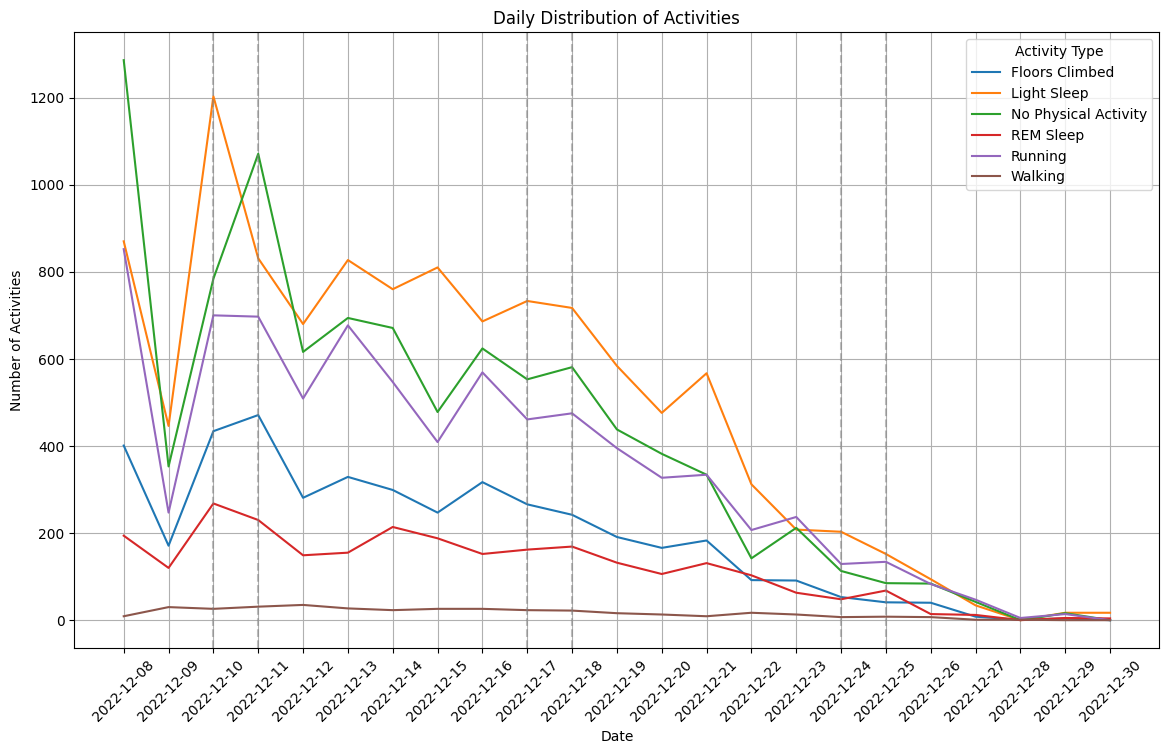

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a string if it's not already in string format
if combined_df['Datetime'].dtype != 'object':
    combined_df['Datetime'] = combined_df['Datetime'].astype(str)

# Step 2: Replace '=' with '-' in the 'Datetime' strings
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

# Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 4: Extract the date and day of the week from 'Datetime'
combined_df['Date'] = combined_df['Datetime'].dt.date
combined_df['DayOfWeek'] = combined_df['Datetime'].dt.dayofweek

# Group by Date and Activity_Type and count number of occurrences
daily_activity_distribution = combined_df.groupby(['Date', 'Activity_Type']).size().unstack(fill_value=0)

# Convert the index to datetime to access weekday information
daily_activity_distribution.index = pd.to_datetime(daily_activity_distribution.index)

# Plot the daily distribution of different types of activities
plt.figure(figsize=(14, 8))
for activity in daily_activity_distribution.columns:
    plt.plot(daily_activity_distribution.index, daily_activity_distribution[activity], label=activity)

# Highlight weekends
weekends = daily_activity_distribution.index[daily_activity_distribution.index.weekday >= 5]
for weekend in weekends:
    plt.axvline(x=weekend, color='grey', linestyle='--', alpha=0.5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.title('Daily Distribution of Activities')
plt.legend(title='Activity Type')
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(daily_activity_distribution.index)))

# Ensure all dates are shown
plt.xticks(ticks=daily_activity_distribution.index, rotation=45)
plt.show()


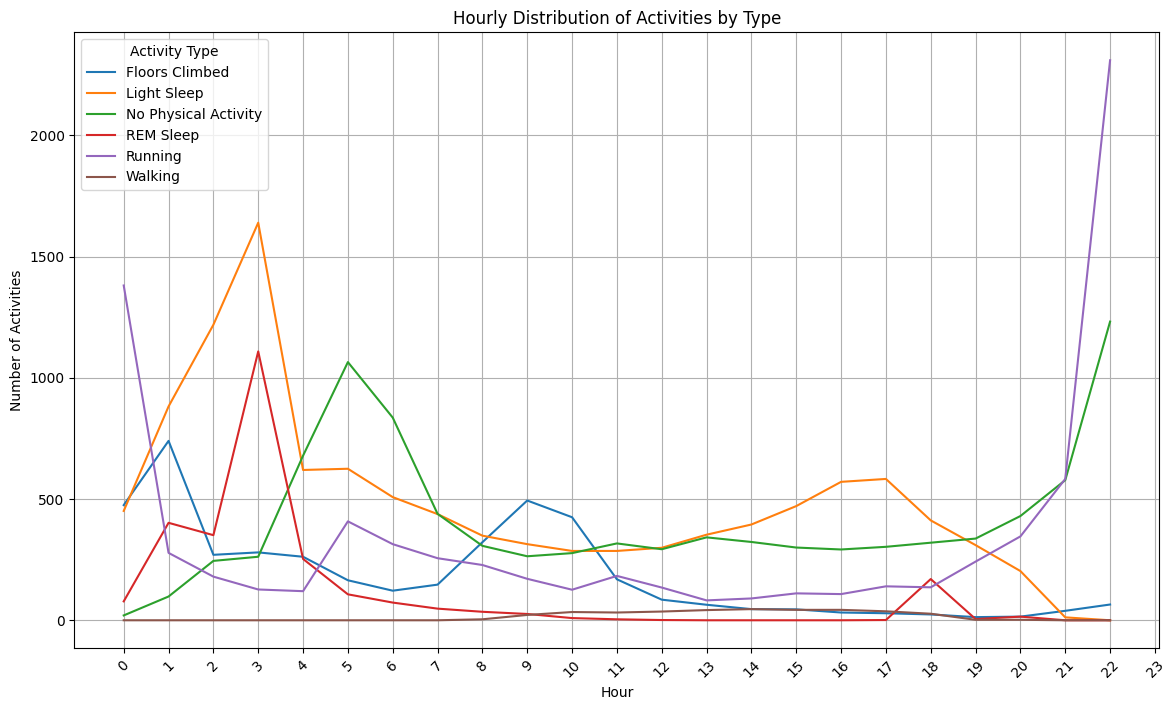

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a string if it's not already in string format
if combined_df['Datetime'].dtype != 'object':
    combined_df['Datetime'] = combined_df['Datetime'].astype(str)

# Step 2: Replace '=' with '-' in the 'Datetime' strings
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

# Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 4: Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Group by Hour and Activity_Type and count number of occurrences
hourly_activity_distribution = combined_df.groupby(['Hour', 'Activity_Type']).size().unstack(fill_value=0)

# Plot the hourly distribution of different types of activities
plt.figure(figsize=(14, 8))
for activity in hourly_activity_distribution.columns:
    plt.plot(hourly_activity_distribution.index, hourly_activity_distribution[activity], label=activity)

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Number of Activities')
plt.title('Hourly Distribution of Activities by Type')
plt.legend(title='Activity Type')
plt.grid(True)
plt.xticks(ticks=range(24), rotation=45)
plt.show()


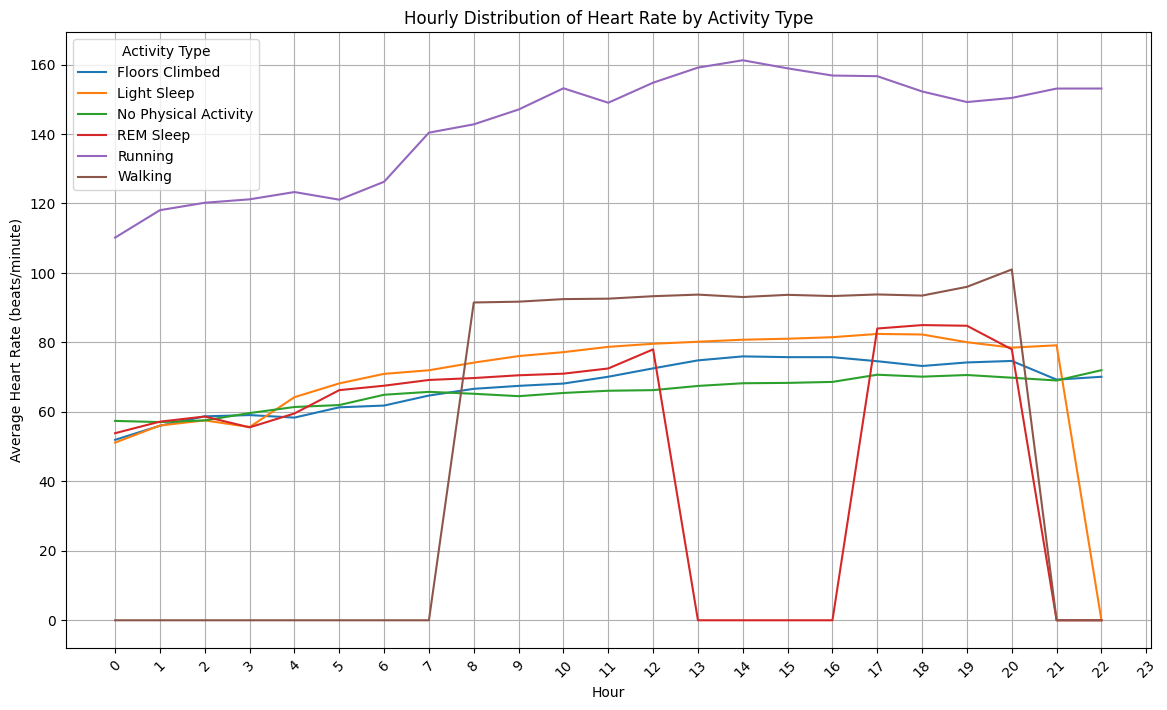

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a string if it's not already in string format
if combined_df['Datetime'].dtype != 'object':
    combined_df['Datetime'] = combined_df['Datetime'].astype(str)

# Step 2: Replace '=' with '-' in the 'Datetime' strings
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

# Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 4: Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Group by Hour and Activity_Type and calculate mean heart rate
hourly_heart_rate = combined_df.groupby(['Hour', 'Activity_Type'])['Heart rate___beats/minute'].mean().unstack(fill_value=0)

# Plot the hourly distribution of heart rate for different activity types
plt.figure(figsize=(14, 8))
for activity in hourly_heart_rate.columns:
    plt.plot(hourly_heart_rate.index, hourly_heart_rate[activity], label=activity)

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Average Heart Rate (beats/minute)')
plt.title('Hourly Distribution of Heart Rate by Activity Type')
plt.legend(title='Activity Type')
plt.grid(True)

# Ensure all hours are shown on x-axis
plt.xticks(ticks=range(24), rotation=45)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a string if it's not already in string format
if combined_df['Datetime'].dtype != 'object':
    combined_df['Datetime'] = combined_df['Datetime'].astype(str)

# Step 2: Replace '=' with '-' in the 'Datetime' strings
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

# Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 4: Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define columns of interest
columns_of_interest = ['Heart rate___beats/minute', 'Calories burned_kcal', 'Exercise duration_s', 'Sleep duration_minutes']

# Create a new DataFrame for the summary
summary_df = pd.DataFrame(index=range(24), columns=columns_of_interest)

# Calculate mean and standard deviation for each hour and format as mean±std
for hour in range(24):
    hour_data = combined_df[combined_df['Hour'] == hour]
    for column in columns_of_interest:
        mean_val = hour_data[column].mean()
        std_val = hour_data[column].std()

        # Modify exercise duration values into 10^-3 format
        if column == 'Exercise duration_s':
            mean_val *= 10**-3
            std_val *= 10**-3

        summary_df.at[hour, column] = f"[{mean_val:.2f},{std_val:.2f}]"

# Output the summary DataFrame to a CSV file
summary_df.to_csv('hourly_summary_modified.csv')

print("Summary table saved to 'hourly_summary_modified.csv'.")
print(summary_df)


Summary table saved to 'hourly_summary_modified.csv'.
   Heart rate___beats/minute Calories burned_kcal Exercise duration_s  \
0              [85.34,28.95]       [122.44,20.57]        [46.20,9.50]   
1              [63.46,19.92]       [139.28,29.23]       [84.67,17.18]   
2              [62.84,17.23]       [120.56,30.52]       [80.13,20.00]   
3              [58.63,13.30]       [114.09,25.30]       [80.78,17.79]   
4              [65.49,15.72]       [105.08,37.08]       [78.31,27.37]   
5              [73.94,22.02]        [33.65,46.24]       [27.15,35.19]   
6              [76.87,23.15]        [34.59,47.94]       [28.28,37.39]   
7              [82.21,29.21]        [36.09,50.69]       [29.82,40.62]   
8              [82.51,29.52]        [47.33,59.08]       [39.54,47.30]   
9              [79.98,27.31]        [53.11,63.04]       [44.90,50.63]   
10             [79.74,26.72]        [50.56,63.26]       [43.55,50.57]   
11             [86.61,30.93]        [37.63,55.49]       [33.64,44.07] 

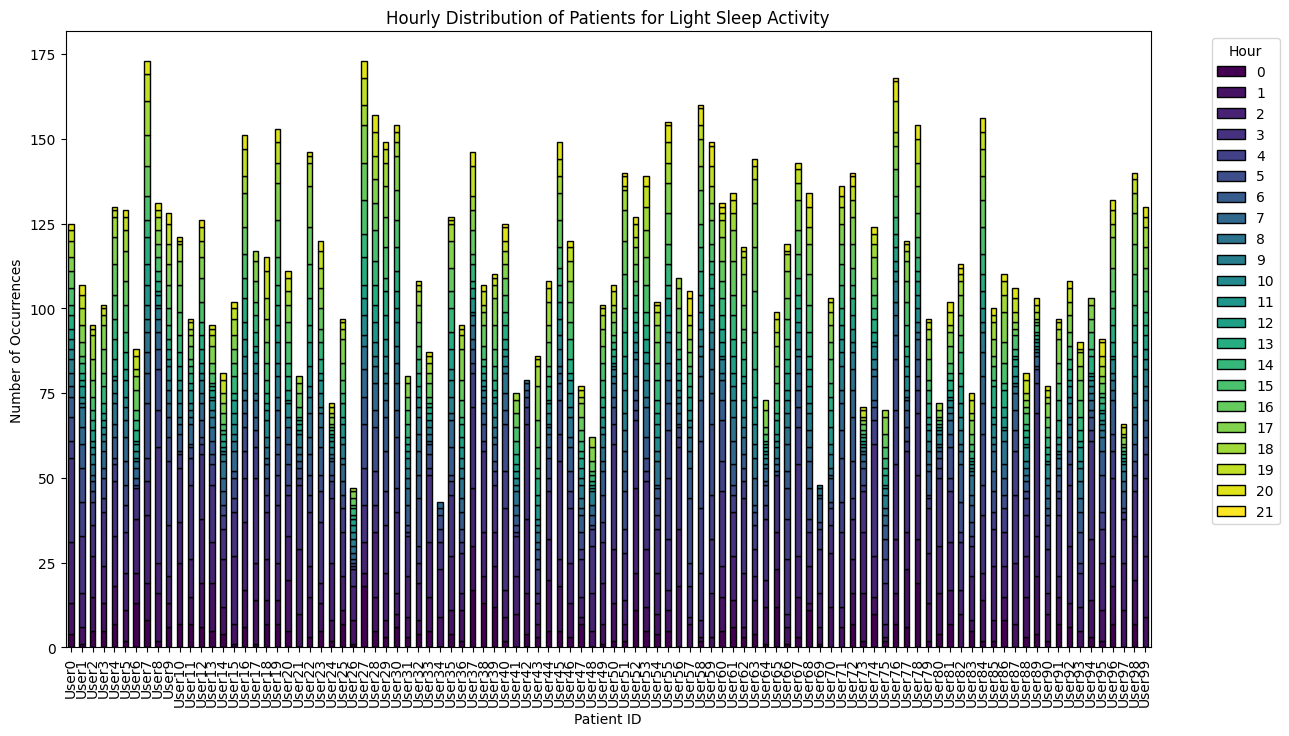

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a string if it's not already in string format
if combined_df['Datetime'].dtype != 'object':
    combined_df['Datetime'] = combined_df['Datetime'].astype(str)

# Step 2: Replace '=' with '-' in the 'Datetime' strings
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

# Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 4: Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Filter data for "Light Sleep" activity
light_sleep_df = combined_df[combined_df['Activity_Type'] == 'Light Sleep']

# Ensure the DataFrame has 100 patients, even if some may not have any entries
patients = [f'User{i}' for i in range(100)]
patient_hour_distribution = light_sleep_df.groupby(['Patient ID', 'Hour']).size().unstack(fill_value=0).reindex(patients, fill_value=0)

# Plot the patient distribution for "Light Sleep" activity
ax = patient_hour_distribution.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis', edgecolor='black')

# Set labels and title
ax.set_xlabel('Patient ID')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Hourly Distribution of Patients for Light Sleep Activity')
ax.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_facecolor('none')
plt.show()


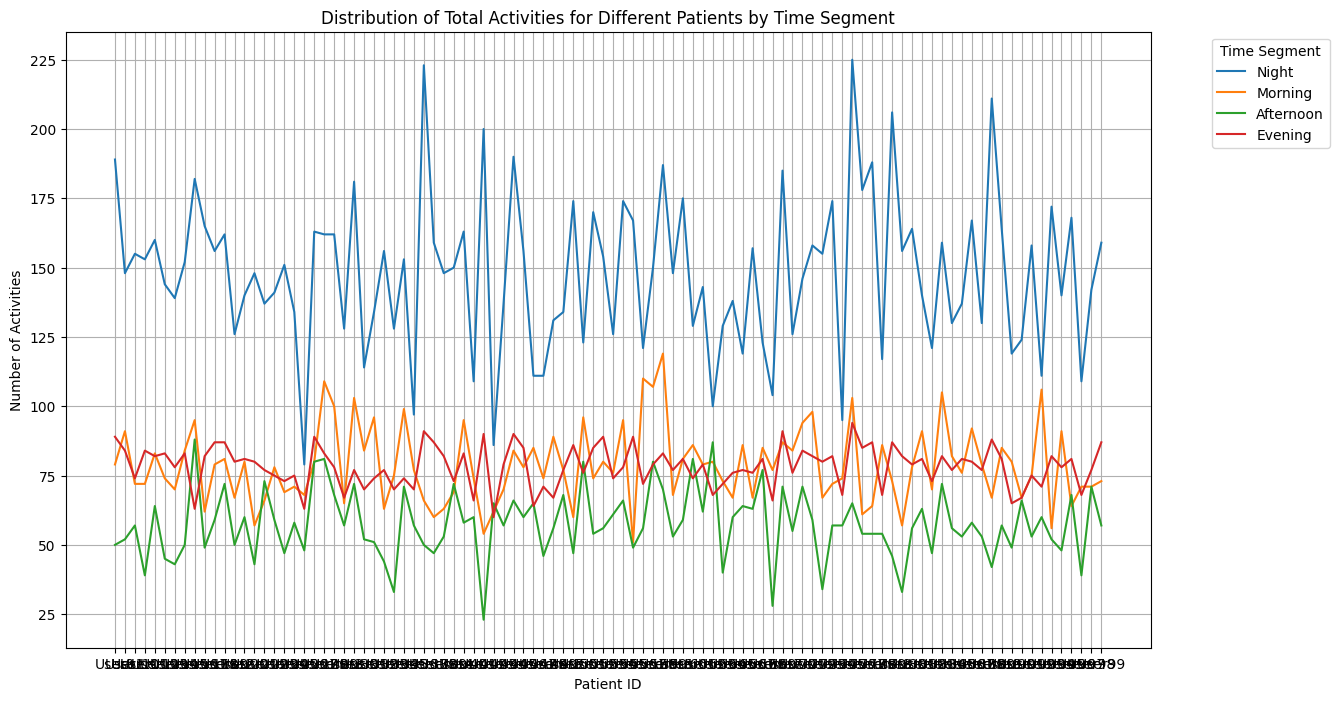

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'].str.replace('=', '-', regex=False), errors='coerce')

# Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define time segments
def get_time_segment(hour):
    if 0 <= hour <= 5:
        return 'Night'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    else:
        return 'Evening'

combined_df['TimeSegment'] = combined_df['Hour'].apply(get_time_segment)

# Group by Patient ID and TimeSegment, and count the occurrences
patient_segment_distribution = combined_df.groupby(['Patient ID', 'TimeSegment']).size().unstack(fill_value=0)

# Plot the patient distribution of total activities for different time segments
plt.figure(figsize=(14, 8))
for segment in ['Night', 'Morning', 'Afternoon', 'Evening']:
    plt.plot(patient_segment_distribution.index, patient_segment_distribution[segment], label=segment)

# Set labels and title
plt.xlabel('Patient ID')
plt.ylabel('Number of Activities')
plt.title('Distribution of Total Activities for Different Patients by Time Segment')
plt.legend(title='Time Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


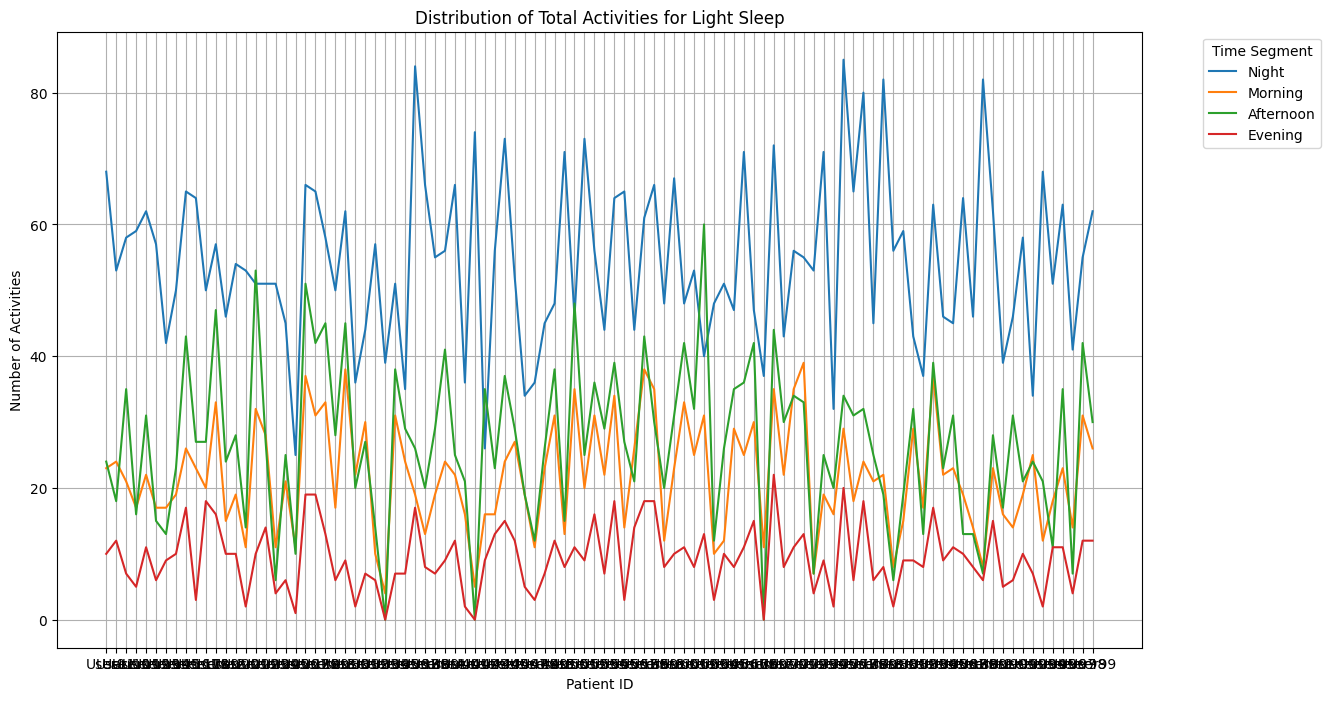

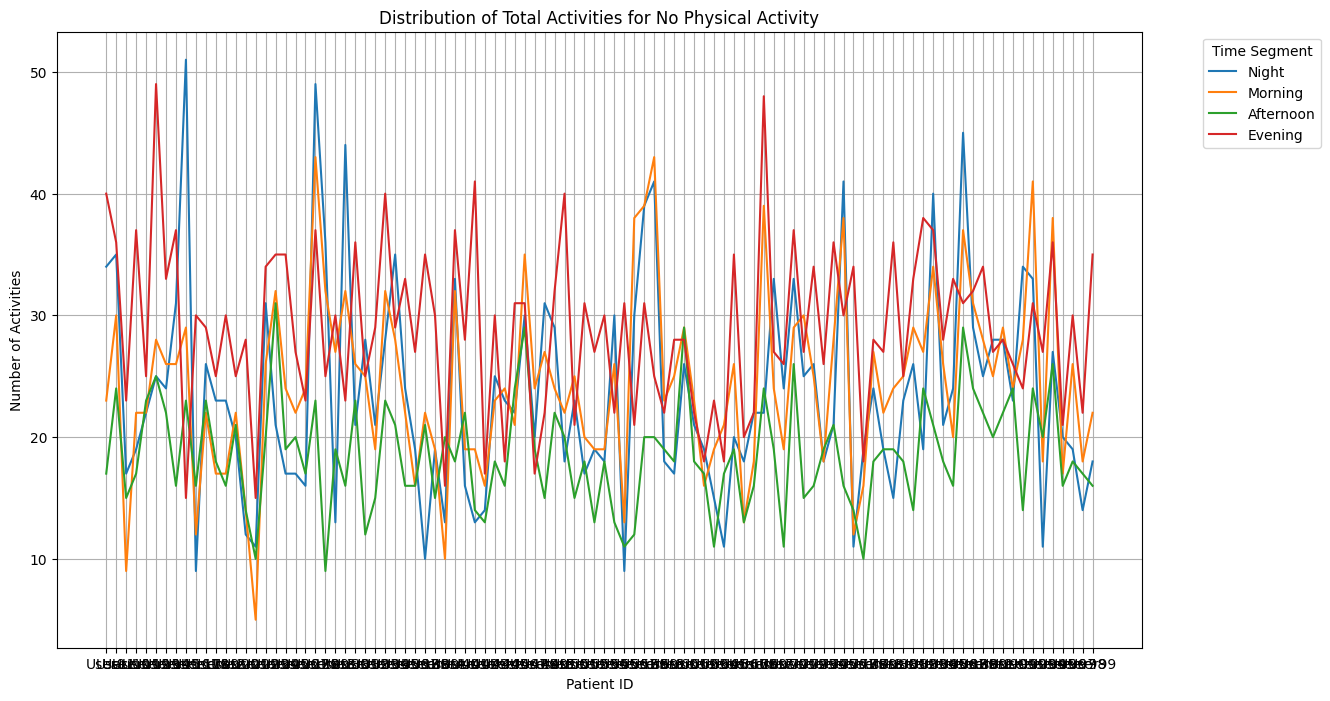

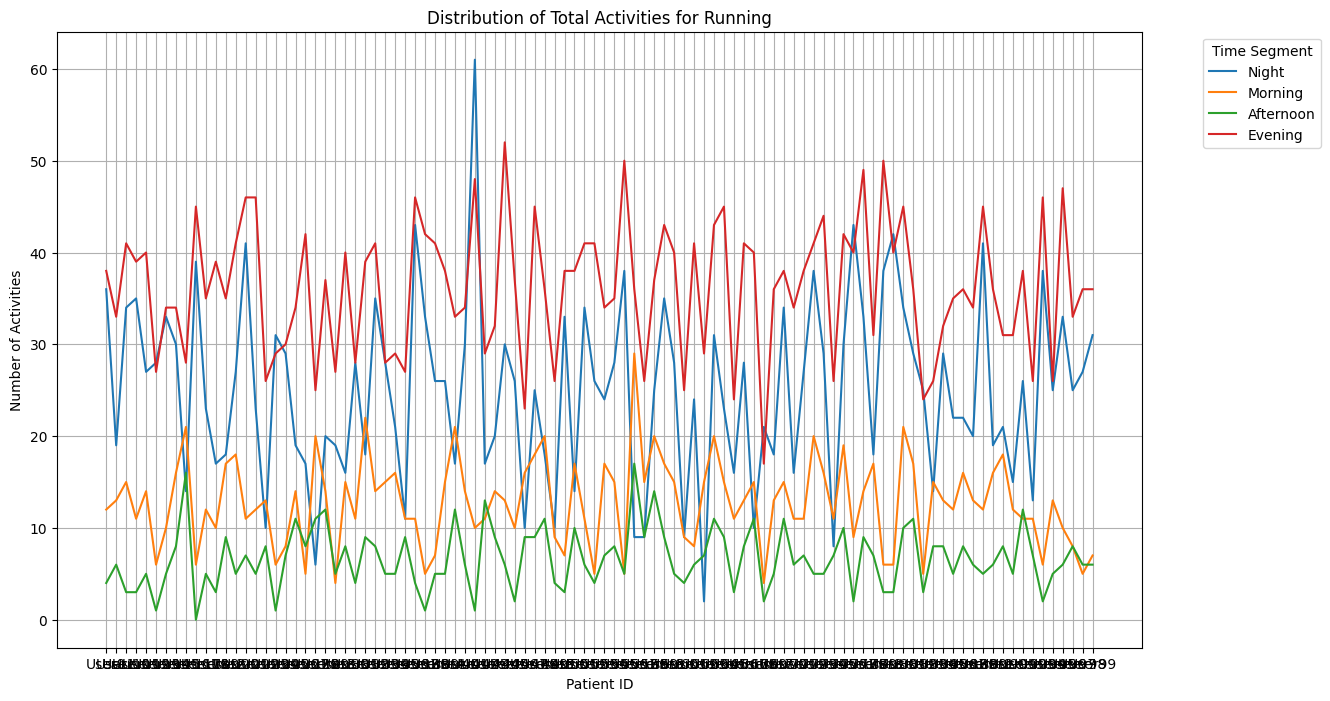

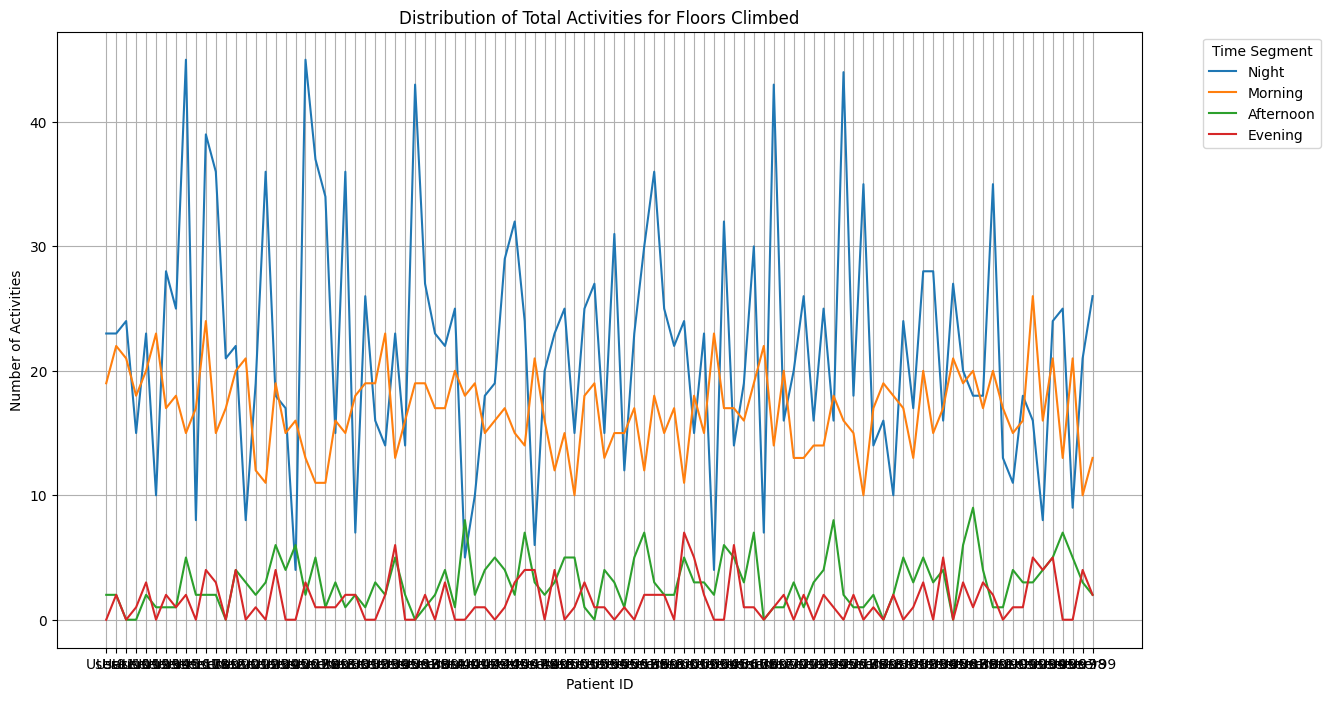

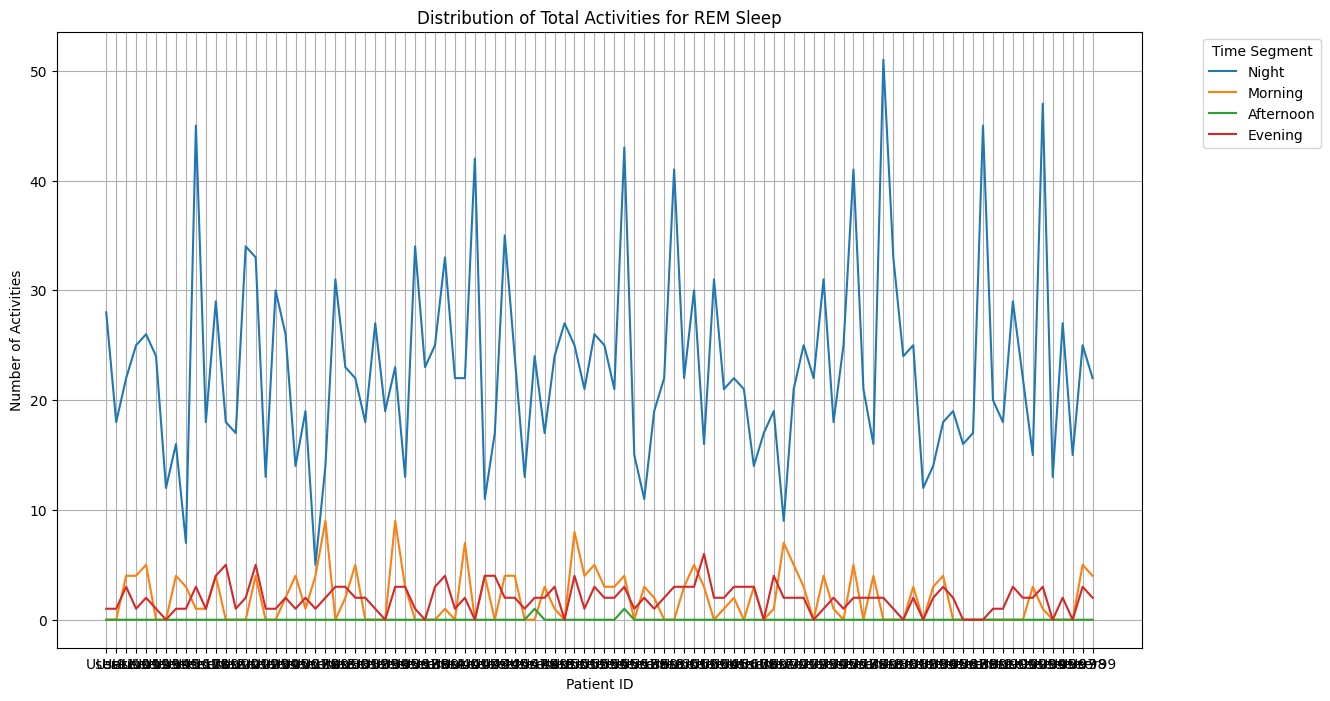

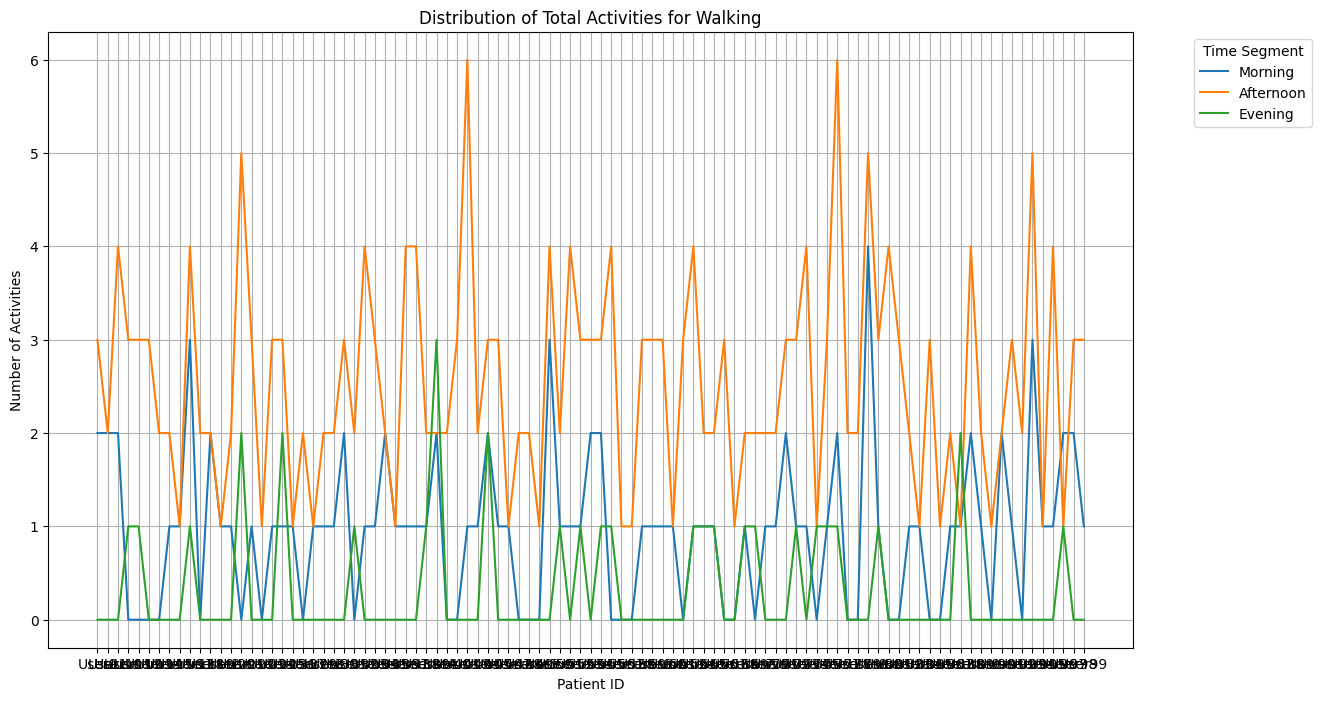

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'].str.replace('=', '-', regex=False), errors='coerce')

# Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define time segments
def get_time_segment(hour):
    if 0 <= hour <= 5:
        return 'Night'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    else:
        return 'Evening'

combined_df['TimeSegment'] = combined_df['Hour'].apply(get_time_segment)

# Define activity types and time segments
activities = ['Light Sleep', 'No Physical Activity', 'Running', 'Floors Climbed', 'REM Sleep', 'Walking']
segments = ['Night', 'Morning', 'Afternoon', 'Evening']

# Plot the patient distribution of total activities for different time segments and activities
for activity in activities:
    plt.figure(figsize=(14, 8))
    activity_df = combined_df[combined_df['Activity_Type'] == activity]
    patient_segment_distribution = activity_df.groupby(['Patient ID', 'TimeSegment']).size().unstack(fill_value=0)

    for segment in segments:
        if segment in patient_segment_distribution.columns:
            plt.plot(patient_segment_distribution.index, patient_segment_distribution[segment], label=segment)

    # Set labels and title
    plt.xlabel('Patient ID')
    plt.ylabel('Number of Activities')
    plt.title(f'Distribution of Total Activities for {activity}')
    plt.legend(title='Time Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a string if it's not already in string format
if combined_df['Datetime'].dtype != 'object':
    combined_df['Datetime'] = combined_df['Datetime'].astype(str)

# Step 2: Replace '=' with '-' in the 'Datetime' strings
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)

# Step 3: Convert the cleaned 'Datetime' column back to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 4: Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Get unique activity types
activity_types = combined_df['Activity_Type'].unique()

# Ensure the DataFrame has 100 patients, even if some may not have any entries
patients = [f'User{i}' for i in range(100)]

# Plot for each activity type and save as PNG
for activity in activity_types:
    activity_df = combined_df[combined_df['Activity_Type'] == activity]
    patient_hour_distribution = activity_df.groupby(['Patient ID', 'Hour']).size().unstack(fill_value=0).reindex(patients, fill_value=0)

    # Plot the patient distribution for the activity
    ax = patient_hour_distribution.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='viridis', edgecolor='black')

    # Set labels and title
    ax.set_xlabel('Patient ID')
    ax.set_ylabel('Number of Occurrences')
    ax.set_title(f'Hourly Distribution of Patients for {activity} Activity')
    ax.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_facecolor('none')

    # Save the plot as a PNG file
    plt.savefig(f'{activity}_activity_distribution.png', bbox_inches='tight')
    plt.close()

print("All plots saved as PNG files.")


All plots saved as PNG files.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from google.colab import files

# Load and preprocess data
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

combined_df['Datetime'] = combined_df['Datetime'].astype(str)
combined_df['Datetime'] = combined_df['Datetime'].str.replace('=', '-', regex=False)
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Reference datetime
start_datetime = pd.Timestamp('2022-12-08 00:00')

# Map datetime to corresponding value
combined_df['Datetime_Value'] = (combined_df['Datetime'] - start_datetime).dt.total_seconds() // 60 + 1
combined_df['Datetime_Value'] = combined_df['Datetime_Value'].astype(int).clip(lower=1, upper=33120)
combined_df = combined_df.sort_values(by=['Patient ID', 'Datetime_Value'])
combined_df.to_csv('sorted_combined_data.csv', index=False)

# Prepare the data for GAN
datetime_values = combined_df['Datetime_Value'].values.reshape(-1, 1)
datetime_values = (datetime_values - datetime_values.min()) / (datetime_values.max() - datetime_values.min())

# Define the GAN components
def build_generator():
    model = Sequential()
    model.add(Dense(64, input_dim=100))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1, activation='sigmoid'))
    model.add(Reshape((1,)))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Dense(256, input_shape=(1,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Keep the discriminator's weights constant during the GAN training
discriminator.trainable = False

# Build and compile the GAN model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
def train_gan(gan, generator, discriminator, data, epochs=10, batch_size=128):
    for epoch in range(epochs):
        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_data = generator.predict(noise)

        # Combine with real data
        real_data = data[np.random.randint(0, data.shape[0], batch_size)]
        combined_data = np.concatenate([real_data, generated_data])

        # Labels for real and fake data
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_data, labels)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        misleading_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, misleading_labels)

        # Print the progress
        if epoch % 200 == 0:
            print(f"Epoch {epoch} | Discriminator Loss: {d_loss[0]}, Accuracy: {d_loss[1]} | Generator Loss: {g_loss}")

# Train the GAN
train_gan(gan, generator, discriminator, datetime_values)

# Generate synthetic Datetime_Values
noise = np.random.normal(0, 1, (100 * 33120, 100))
synthetic_datetime_values = generator.predict(noise)
synthetic_datetime_values = synthetic_datetime_values * (datetime_values.max() - datetime_values.min()) + datetime_values.min()
synthetic_datetime_values = synthetic_datetime_values.astype(int)

# Convert Datetime_Values back to actual datetimes
synthetic_datetimes = [start_datetime + pd.Timedelta(minutes=int(val - 1)) for val in synthetic_datetime_values]

# Create synthetic data for 100 new patients
synthetic_data = []

for patient_id in range(100, 200):
    for dt_value, dt in zip(synthetic_datetime_values[patient_id*33120:(patient_id+1)*33120], synthetic_datetimes[patient_id*33120:(patient_id+1)*33120]):
        synthetic_data.append({
            'Patient ID': f'User{patient_id}',
            'Datetime_Value': dt_value,
            'Datetime': dt
        })

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Save the synthetic data to a CSV file
synthetic_df.to_csv('synthetic_patient_data_with_gan.csv', index=False)

# Download the CSV file
files.download('synthetic_patient_data_with_gan.csv')

print("Synthetic data for 100 new patients saved and downloaded as 'synthetic_patient_data_with_gan.csv'.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | Discriminator Loss: 0.6879485845565796, Accuracy: 0.5 | Generator Loss: [array(0.6879486, dtype=float32), array(0.6879486, dtype=float32), array(0.5, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
103500/103500 ━━━━━━━━━━━━━━━━━━━━ 162s 2ms/step


<ipython-input-55-ef937e6f6285>:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  synthetic_datetimes = [start_datetime + pd.Timedelta(minutes=int(val - 1)) for val in synthetic_datetime_values]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Synthetic data for 100 new patients saved and downloaded as 'synthetic_patient_data_with_gan.csv'.


In [ ]:
import pandas as pd
from google.colab import files

# File path
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to proper datetime object
combined_df['Datetime'] = combined_df['Datetime'].astype(str).str.replace('=', '-', regex=False)
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Reference datetime
start_datetime = pd.Timestamp('2022-12-08 00:00')

# Map datetime to corresponding value
combined_df['Datetime_Value'] = (combined_df['Datetime'] - start_datetime).dt.total_seconds() // 60 + 1
combined_df['Datetime_Value'] = combined_df['Datetime_Value'].astype(int).clip(lower=1, upper=33120)
combined_df = combined_df.sort_values(by=['Patient ID', 'Datetime_Value'])
combined_df.to_csv('sorted_combined_data.csv', index=False)

import numpy as np

# Load sorted data
combined_df = pd.read_csv('sorted_combined_data.csv')

# Extract the distribution of Datetime_Value
datetime_value_distribution = combined_df['Datetime_Value'].value_counts(normalize=True)

# Generate synthetic Datetime_Values based on the distribution
synthetic_data = []

# Generate data for 100 new patients
for patient_id in range(100, 200):
    synthetic_datetime_values = np.random.choice(
        datetime_value_distribution.index,
        size=combined_df.shape[0] // 100,
        p=datetime_value_distribution.values
    )

    # Convert Datetime_Values back to datetimes
    synthetic_datetimes = [start_datetime + pd.Timedelta(minutes=int(val - 1)) for val in synthetic_datetime_values]

    for dt_value, dt in zip(synthetic_datetime_values, synthetic_datetimes):
        synthetic_data.append({
            'Patient ID': f'User{patient_id}',
            'Datetime_Value': dt_value,
            'Datetime': dt
        })

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Print the number of datetime rows for each patient
patient_datetime_counts = synthetic_df.groupby('Patient ID').size()
print(patient_datetime_counts)

# Save the synthetic data to a CSV file
synthetic_df.to_csv('synthetic_patient_data_with_simple_method.csv', index=False)

# Download the CSV file
files.download('synthetic_patient_data_with_simple_method.csv')

print("Synthetic data for 100 new patients saved and downloaded as 'synthetic_patient_data_with_simple_method.csv'.")


In [ ]:
import pandas as pd
import numpy as np

# Load the datasets
sorted_synthetic_patient_data = pd.read_csv('sorted_synthetic_patient_data.csv')
synthetic_data_with_activity_type = pd.read_csv('synthetic_data_with_activity_type.csv')

# Define the reverse activity mapping
reverse_activity_mapping = {
    1: 'Light Sleep',
    2: 'No Physical Activity',
    3: 'Running',
    4: 'Floors Climbed',
    5: 'REM Sleep',
    6: 'Walking'
}

# Helper function to map Activity_Type to original string values
def map_activity_type(value):
    return reverse_activity_mapping[value]

# Map Activity_Type in activity data to activity names
synthetic_data_with_activity_type['Activity_Type'] = synthetic_data_with_activity_type['Activity_Type'].replace(reverse_activity_mapping)

# For each patient, assign activities based on the distribution and insert activity details
new_rows = []
for patient in sorted_synthetic_patient_data['Patient ID'].unique():
    patient_data = sorted_synthetic_patient_data[sorted_synthetic_patient_data['Patient ID'] == patient].copy()

    # Randomly assign Activity_Type based on the original distribution
    activity_distribution = synthetic_data_with_activity_type['Activity_Type'].value_counts(normalize=True)
    assigned_activities = np.random.choice(activity_distribution.index, size=len(patient_data), p=activity_distribution.values)

    patient_data['Activity_Type'] = assigned_activities

    # Insert activity details from synthetic_data_with_activity_type
    for index, row in patient_data.iterrows():
        activity = row['Activity_Type']
        matching_rows = synthetic_data_with_activity_type[synthetic_data_with_activity_type['Activity_Type'] == activity]
        if not matching_rows.empty:
            random_row = matching_rows.sample(n=1).iloc[0]
            for col in synthetic_data_with_activity_type.columns:
                if col not in ['Patient ID', 'Datetime', 'Activity_Type']:
                    patient_data.at[index, col] = random_row[col]

    new_rows.append(patient_data)

# Combine all the patient data
final_combined_data = pd.concat(new_rows, ignore_index=True)

# Reorder the columns as specified
column_order = [
    'Patient ID', 'Datetime', 'Code', 'Activity_Type', 'Heart rate___beats/minute',
    'Calories burned_kcal', 'Exercise duration_s', 'Sleep duration_minutes',
    'Sleep type duration_minutes', 'Floors climbed___floors'
]
final_combined_data = final_combined_data[column_order]

# Save the final DataFrame to a new CSV file
final_combined_data.to_csv('Synthetic_Combined_Data.csv', index=False)


print("Final synthetic combined data saved and downloaded as 'Synthetic_Combined_Data.csv'.")


<ipython-input-59-c71ad6a01ebd>:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '370' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  patient_data.at[index, col] = random_row[col]
<ipython-input-59-c71ad6a01ebd>:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'LA11836-6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  patient_data.at[index, col] = random_row[col]
<ipython-input-59-c71ad6a01ebd>:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'LA11836-6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  patient_data.at[index, col] = random_row[col]
<ipython-input-59-c71ad6a01ebd>:44: FutureWarning: Setting an item 

Final synthetic combined data saved and downloaded as 'Synthetic_Combined_Data.csv'.


In [ ]:
import pandas as pd
import numpy as np

# Load the original data to calculate the hourly activity distribution
file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'].str.replace('=', '-', regex=False), errors='coerce')
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define activities and calculate the hourly distribution
activities = ['Light Sleep', 'No Physical Activity', 'Running', 'Floors Climbed', 'REM Sleep', 'Walking']
grouped = combined_df.groupby(['Hour', 'Activity_Type']).size().unstack(fill_value=0)
percentages = grouped.div(grouped.sum(axis=1), axis=0).fillna(0) * 100

# Load sorted synthetic data and ensure 'Datetime' is in datetime format
sorted_synthetic_patient_data = pd.read_csv('sorted_synthetic_patient_data.csv')
sorted_synthetic_patient_data['Datetime'] = pd.to_datetime(sorted_synthetic_patient_data['Datetime'], errors='coerce')
synthetic_data_with_activity_type = pd.read_csv('synthetic_data_with_activity_type.csv')

# Initialize empty list for new synthetic data rows
new_rows = []

# Assign activities for each hour based on the calculated distribution
for patient in sorted_synthetic_patient_data['Patient ID'].unique():
    patient_data = sorted_synthetic_patient_data[sorted_synthetic_patient_data['Patient ID'] == patient].copy()

    # Assign activities based on the hourly distribution
    for hour in range(24):
        # Check if the hour exists in percentages
        if hour in percentages.index:
            hourly_data = percentages.loc[hour].reindex(activities, fill_value=0)
            activity_distribution = hourly_data / hourly_data.sum()  # Normalize to make a valid probability distribution
        else:
            # If no data for the hour, skip or set a default distribution
            activity_distribution = pd.Series([1/len(activities)] * len(activities), index=activities)

        # Filter rows of patient_data for the current hour
        hourly_patient_data = patient_data[patient_data['Datetime'].dt.hour == hour].copy()
        assigned_activities = np.random.choice(activity_distribution.index, size=len(hourly_patient_data), p=activity_distribution.values)
        hourly_patient_data['Activity_Type'] = assigned_activities

        # Insert activity details from the reference dataset
        for index, row in hourly_patient_data.iterrows():
            activity = row['Activity_Type']
            matching_rows = synthetic_data_with_activity_type[synthetic_data_with_activity_type['Activity_Type'] == activity]
            if not matching_rows.empty:
                random_row = matching_rows.sample(n=1).iloc[0]
                for col in synthetic_data_with_activity_type.columns:
                    if col not in ['Patient ID', 'Datetime', 'Activity_Type']:
                        hourly_patient_data.at[index, col] = random_row[col]

        new_rows.append(hourly_patient_data)

# Combine all synthetic patient data
final_combined_data = pd.concat(new_rows, ignore_index=True)

# Reorder columns as specified
column_order = [
    'Patient ID', 'Datetime', 'Code', 'Activity_Type', 'Heart rate___beats/minute',
    'Calories burned_kcal', 'Exercise duration_s', 'Sleep duration_minutes',
    'Sleep type duration_minutes', 'Floors climbed___floors'
]
final_combined_data = final_combined_data[column_order]

# Save the final combined DataFrame to CSV
final_combined_data.to_csv('Synthetic_Combined_Data.csv', index=False)
print("Final synthetic combined data saved as 'Synthetic_Combined_Data.csv'.")


<ipython-input-16-bd32a6edb862>:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  synthetic_data_with_activity_type = pd.read_csv('synthetic_data_with_activity_type.csv')
<ipython-input-16-bd32a6edb862>:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '93830-8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  hourly_patient_data.at[index, col] = random_row[col]
<ipython-input-16-bd32a6edb862>:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '93830-8' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  hourly_patient_data.at[index, col] = random_row[col]
<ipython-input-16-bd32a6edb862>:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futur

Final synthetic combined data saved as 'Synthetic_Combined_Data.csv'.


In [ ]:
import pandas as pd

# Load the CSV file
file_path = 'Synthetic_Combined_Data.csv'
final_combined_data = pd.read_csv(file_path)

# Change all values in 'Floors climbed___floors' from 0 to 1
final_combined_data['Floors climbed___floors'] = final_combined_data['Floors climbed___floors'].replace(0, 1)

# Save the updated DataFrame back to the CSV
final_combined_data.to_csv('Synthetic_Combined_Data1.csv', index=False)

print("All 'Floors climbed___floors' values have been changed from 0 to 1 in 'Synthetic_Combined_Data1.csv'.")


All 'Floors climbed___floors' values have been changed from 0 to 1 in 'Synthetic_Combined_Data.csv'.


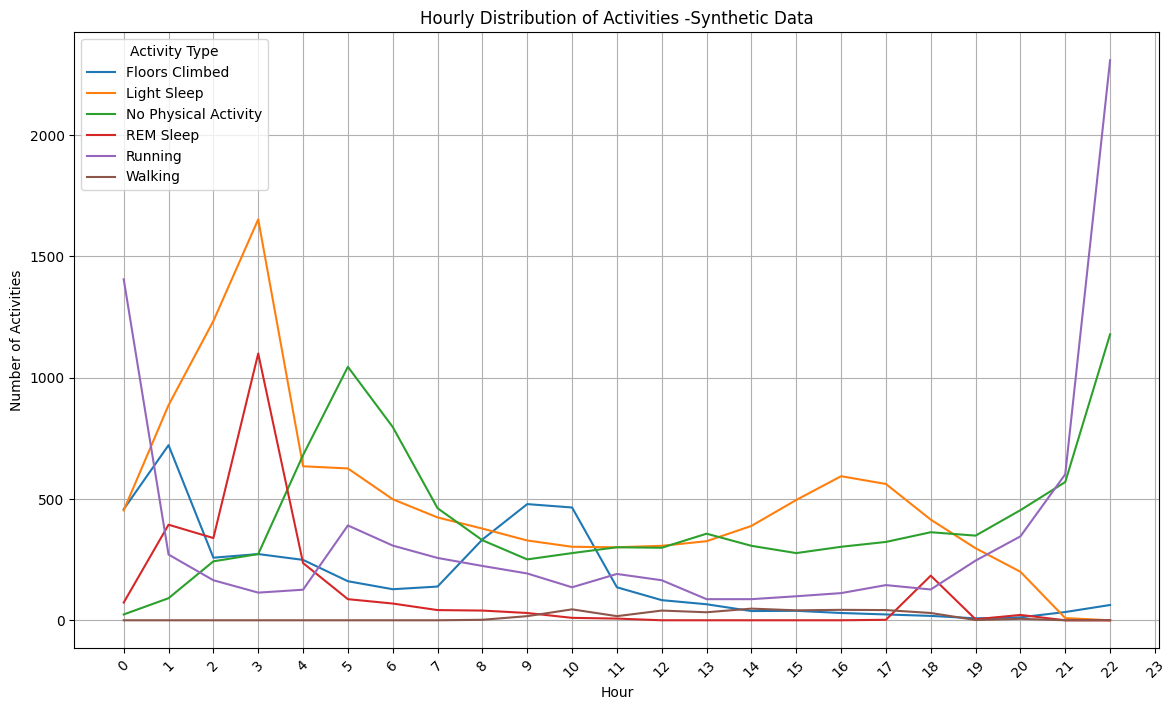

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = 'Synthetic_Combined_Data1.csv'

# Load data
synthetic_combined_df = pd.read_csv(file_path)

# Convert 'Datetime' to proper datetime object
synthetic_combined_df['Datetime'] = pd.to_datetime(synthetic_combined_df['Datetime'], errors='coerce')

# Extract the hour from Datetime
synthetic_combined_df['Hour'] = synthetic_combined_df['Datetime'].dt.hour

# Group by Hour and Activity_Type and count number of occurrences
hourly_activity_distribution = synthetic_combined_df.groupby(['Hour', 'Activity_Type']).size().unstack(fill_value=0)

# Plot the hourly distribution of different types of activities
plt.figure(figsize=(14, 8))
for activity in hourly_activity_distribution.columns:
    plt.plot(hourly_activity_distribution.index, hourly_activity_distribution[activity], label=activity)

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Number of Activities')
plt.title('Hourly Distribution of Activities -Synthetic Data')
plt.legend(title='Activity Type')
plt.grid(True)
plt.xticks(ticks=range(24), rotation=45)
plt.show()


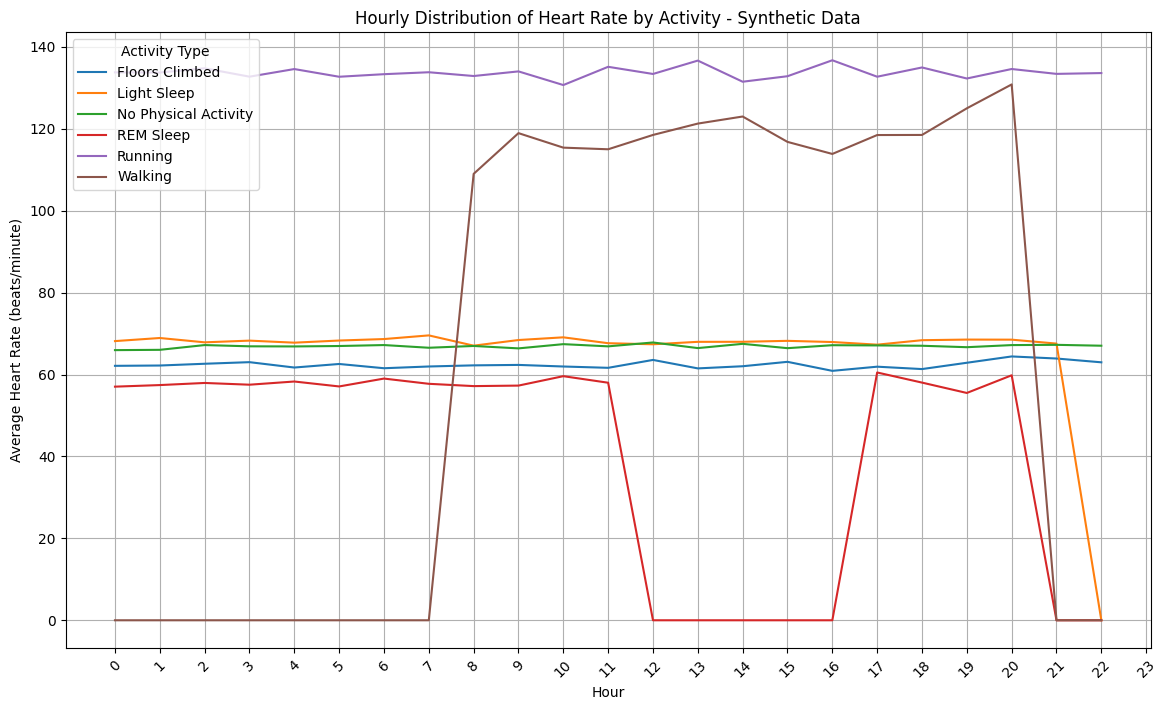

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = 'Synthetic_Combined_Data.csv'

# Load data
synthetic_combined_df = pd.read_csv(file_path)

# Convert 'Datetime' to proper datetime object
synthetic_combined_df['Datetime'] = pd.to_datetime(synthetic_combined_df['Datetime'], errors='coerce')

# Extract the hour from Datetime
synthetic_combined_df['Hour'] = synthetic_combined_df['Datetime'].dt.hour

# Group by Hour and Activity_Type and calculate mean heart rate
hourly_heart_rate = synthetic_combined_df.groupby(['Hour', 'Activity_Type'])['Heart rate___beats/minute'].mean().unstack(fill_value=0)

# Plot the hourly distribution of heart rate for different activity types
plt.figure(figsize=(14, 8))
for activity in hourly_heart_rate.columns:
    plt.plot(hourly_heart_rate.index, hourly_heart_rate[activity], label=activity)

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Average Heart Rate (beats/minute)')
plt.title('Hourly Distribution of Heart Rate by Activity - Synthetic Data')
plt.legend(title='Activity Type', loc='upper left')
plt.grid(True)

# Ensure all hours are shown on x-axis
plt.xticks(ticks=range(24), rotation=45)
plt.show()


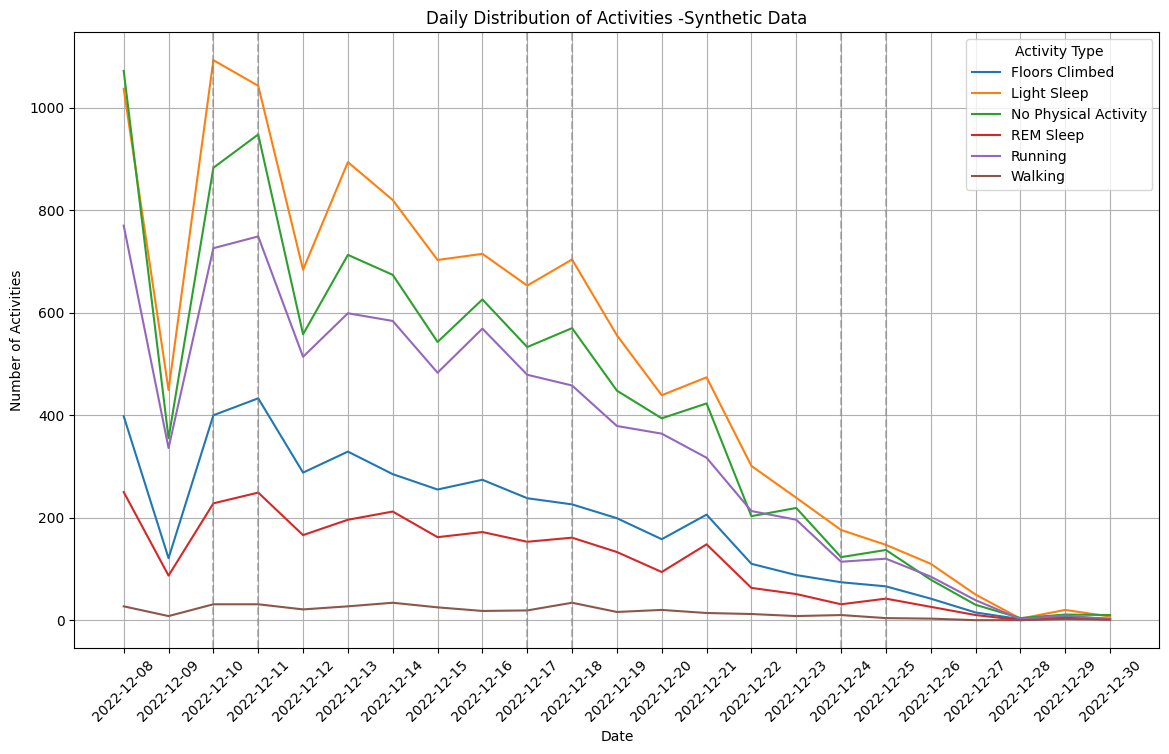

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path
file_path = 'Synthetic_Combined_Data.csv'

# Load data
synthetic_combined_df = pd.read_csv(file_path)

# Convert 'Datetime' to proper datetime object
synthetic_combined_df['Datetime'] = pd.to_datetime(synthetic_combined_df['Datetime'], errors='coerce')

# Extract the date and day of the week from 'Datetime'
synthetic_combined_df['Date'] = synthetic_combined_df['Datetime'].dt.date
synthetic_combined_df['DayOfWeek'] = synthetic_combined_df['Datetime'].dt.dayofweek

# Group by Date and Activity_Type and count number of occurrences
daily_activity_distribution = synthetic_combined_df.groupby(['Date', 'Activity_Type']).size().unstack(fill_value=0)

# Convert the index to datetime to access weekday information
daily_activity_distribution.index = pd.to_datetime(daily_activity_distribution.index)

# Plot the daily distribution of different types of activities
plt.figure(figsize=(14, 8))
for activity in daily_activity_distribution.columns:
    plt.plot(daily_activity_distribution.index, daily_activity_distribution[activity], label=activity)

# Highlight weekends
weekends = daily_activity_distribution.index[daily_activity_distribution.index.weekday >= 5]
for weekend in weekends:
    plt.axvline(x=weekend, color='grey', linestyle='--', alpha=0.5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.title('Daily Distribution of Activities -Synthetic Data')
plt.legend(title='Activity Type')
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(daily_activity_distribution.index)))

# Ensure all dates are shown
plt.xticks(ticks=daily_activity_distribution.index, rotation=45)
plt.show()


         Light Sleep No Physical Activity           Running    Floors Climbed  \
0    [18.64%, 7.52%]       [1.04%, 1.90%]  [58.34%, 10.13%]   [18.83%, 8.35%]   
1    [37.58%, 9.66%]       [3.82%, 4.08%]   [11.48%, 7.49%]  [30.53%, 10.27%]   
2   [54.62%, 12.50%]      [11.13%, 7.75%]    [7.30%, 6.02%]   [11.79%, 7.25%]   
3    [48.37%, 7.49%]       [7.99%, 4.56%]    [3.32%, 3.38%]    [7.95%, 4.80%]   
4   [32.69%, 10.30%]     [35.66%, 11.70%]    [6.55%, 5.41%]   [12.86%, 6.69%]   
5   [27.31%, 10.70%]     [45.26%, 11.48%]   [17.01%, 8.41%]    [6.78%, 5.62%]   
6   [28.07%, 11.63%]     [43.79%, 10.51%]  [17.05%, 10.22%]    [7.27%, 6.37%]   
7   [32.35%, 12.08%]     [34.31%, 14.13%]  [19.17%, 12.49%]   [10.87%, 9.74%]   
8   [28.73%, 13.02%]     [25.57%, 12.00%]  [16.76%, 10.84%]  [25.87%, 12.46%]   
9   [25.11%, 12.43%]     [19.30%, 11.31%]  [15.23%, 10.53%]  [36.86%, 13.13%]   
10  [24.95%, 12.47%]     [22.42%, 12.35%]   [10.70%, 8.69%]  [37.61%, 14.62%]   
11  [31.33%, 15.96%]     [32

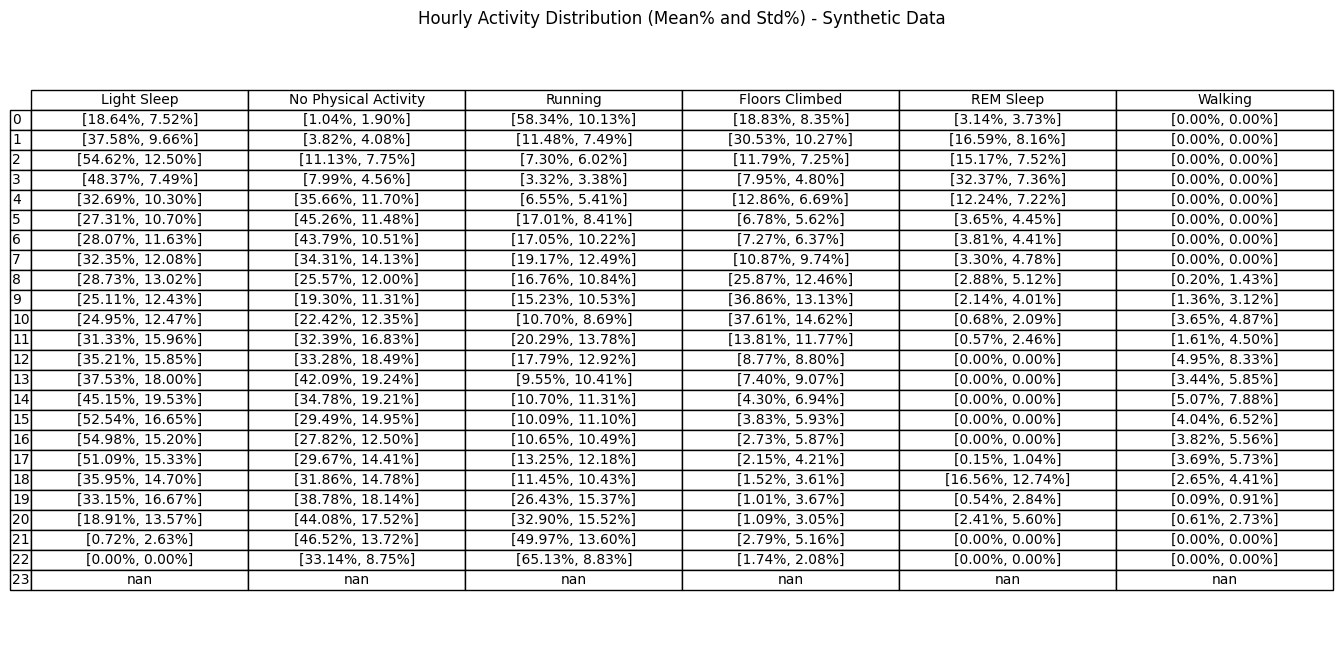

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the synthetic combined data CSV file
file_path = 'Synthetic_Combined_Data1.csv'
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define activities of interest
activities = ['Light Sleep', 'No Physical Activity', 'Running', 'Floors Climbed', 'REM Sleep', 'Walking']

# Group by patient, hour, and activity type, count the occurrences, and calculate the percentages
grouped = combined_df.groupby(['Patient ID', 'Hour', 'Activity_Type']).size().unstack(fill_value=0)
percentages = grouped.div(grouped.sum(axis=1), axis=0).fillna(0) * 100

# Initialize a DataFrame to store the results
results = pd.DataFrame(index=range(24), columns=activities)

# Calculate mean and standard deviation for each hour and activity
for hour in range(24):
    if hour in percentages.index.get_level_values('Hour'):
        hourly_data = percentages.xs(hour, level='Hour').fillna(0)
        mean_values = hourly_data.mean()
        std_values = hourly_data.std()

        for activity in activities:
            mean_std_format = f"[{mean_values.get(activity, 0):.2f}%, {std_values.get(activity, 0):.2f}%]"
            results.at[hour, activity] = mean_std_format

# Display the results
print(results)

# Save the table as a PNG file
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results.values, colLabels=results.columns, rowLabels=results.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Hourly Activity Distribution (Mean% and Std%) - Synthetic Data')

# Save as PNG
plt.savefig('hourly_activity_distribution_synthetic_data.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

print("Table saved as 'hourly_activity_distribution.png'.")


In [ ]:
import pandas as pd
import numpy as np

# File path for the synthetic combined data
file_path = 'Synthetic_Combined_Data1.csv'

# Load data
combined_df = pd.read_csv(file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Step 1: Convert 'Datetime' to a proper datetime object
combined_df['Datetime'] = pd.to_datetime(combined_df['Datetime'], errors='coerce')

# Step 2: Extract the hour from 'Datetime'
combined_df['Hour'] = combined_df['Datetime'].dt.hour

# Define columns of interest
columns_of_interest = ['Heart rate___beats/minute', 'Calories burned_kcal', 'Exercise duration_s', 'Sleep duration_minutes']

# Create a new DataFrame for the summary
summary_df = pd.DataFrame(index=range(24), columns=columns_of_interest)

# Calculate mean and standard deviation for each hour and format as mean±std
for hour in range(24):
    hour_data = combined_df[combined_df['Hour'] == hour]
    for column in columns_of_interest:
        mean_val = hour_data[column].mean()
        std_val = hour_data[column].std()

        # Modify exercise duration values into 10^-3 format
        if column == 'Exercise duration_s':
            mean_val *= 10**-3
            std_val *= 10**-3

        summary_df.at[hour, column] = f"[{mean_val:.2f},{std_val:.2f}]"

# Output the summary DataFrame to a CSV file
summary_df.to_csv('hourly_summary_modified_synthetic_data.csv')

print("Summary table saved to 'hourly_summary_modified.csv'.")
print(summary_df)




Summary table saved to 'hourly_summary_modified.csv'.
   Heart rate___beats/minute Calories burned_kcal Exercise duration_s  \
0             [104.88,38.26]        [54.64,53.82]       [35.71,30.20]   
1              [72.27,25.25]        [54.45,53.44]       [35.31,29.07]   
2              [70.62,21.61]        [55.34,53.17]       [35.15,31.21]   
3              [66.43,16.65]        [58.11,54.77]       [33.69,30.32]   
4              [69.88,20.04]        [52.02,54.33]       [32.34,28.44]   
5              [77.78,27.36]        [57.24,53.98]       [33.69,28.96]   
6              [78.20,27.64]        [55.59,53.50]       [37.14,31.34]   
7              [79.80,29.34]        [56.08,54.02]       [35.29,29.95]   
8              [76.85,28.24]        [59.76,55.01]       [38.58,30.43]   
9              [75.94,27.84]        [62.75,54.11]       [38.09,29.84]   
10             [74.42,24.74]        [68.36,55.81]       [40.69,31.53]   
11             [80.85,30.53]        [54.19,53.57]       [38.18,31.65] 

Comparison summary table saved to 'hourly_comparison_summary.csv'.
Table image saved to 'hourly_comparison_summary_table.png'.
          HR (bpm)    HR (bpm) Syn Calories (kcal) Calories (kcal) Syn  \
0    [85.34,28.95]  [104.88,38.26]  [122.44,20.57]       [54.64,53.82]   
1    [63.46,19.92]   [72.27,25.25]  [139.28,29.23]       [54.45,53.44]   
2    [62.84,17.23]   [70.62,21.61]  [120.56,30.52]       [55.34,53.17]   
3    [58.63,13.30]   [66.43,16.65]  [114.09,25.30]       [58.11,54.77]   
4    [65.49,15.72]   [69.88,20.04]  [105.08,37.08]       [52.02,54.33]   
5    [73.94,22.02]   [77.78,27.36]   [33.65,46.24]       [57.24,53.98]   
6    [76.87,23.15]   [78.20,27.64]   [34.59,47.94]       [55.59,53.50]   
7    [82.21,29.21]   [79.80,29.34]   [36.09,50.69]       [56.08,54.02]   
8    [82.51,29.52]   [76.85,28.24]   [47.33,59.08]       [59.76,55.01]   
9    [79.98,27.31]   [75.94,27.84]   [53.11,63.04]       [62.75,54.11]   
10   [79.74,26.72]   [74.42,24.74]   [50.56,63.26]       [6

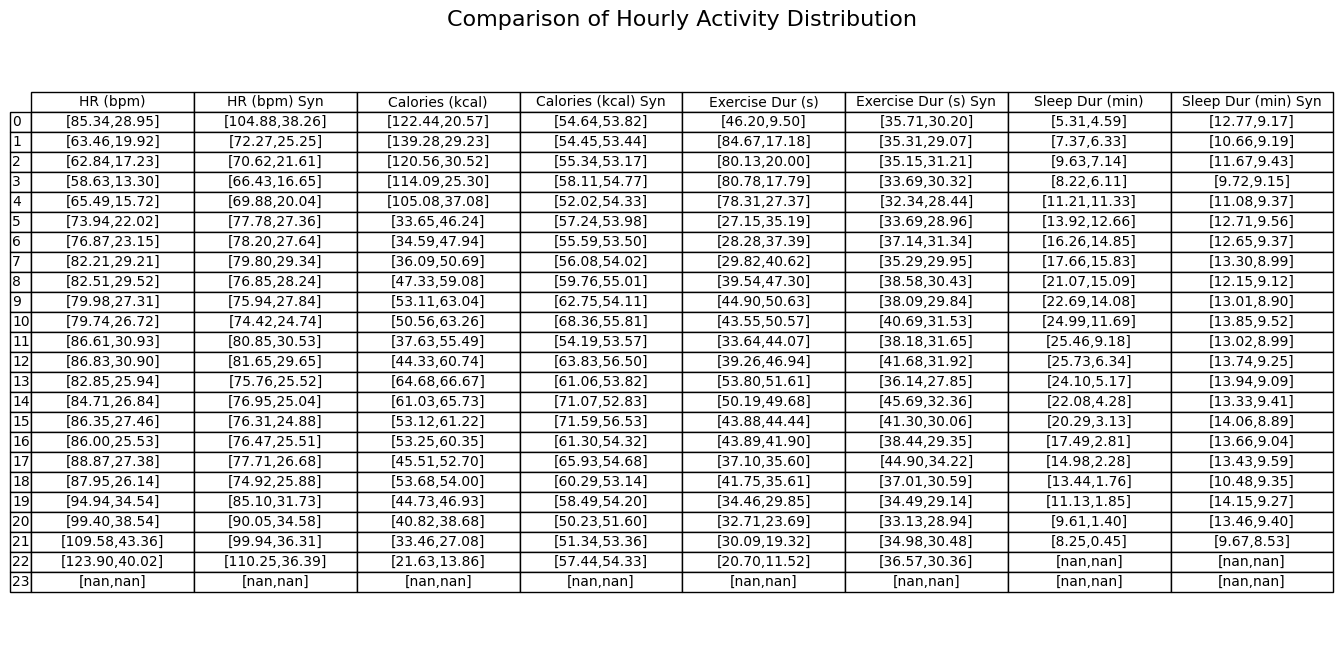

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File path for the original and synthetic data
original_file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'
synthetic_file_path = 'Synthetic_Combined_Data1.csv'

# Load original data
original_df = pd.read_csv(original_file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to a proper datetime object for original data
original_df['Datetime'] = pd.to_datetime(original_df['Datetime'].str.replace('=', '-', regex=False), errors='coerce')

# Extract the hour from 'Datetime'
original_df['Hour'] = original_df['Datetime'].dt.hour

# Load synthetic data
synthetic_df = pd.read_csv(synthetic_file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})

# Convert 'Datetime' to a proper datetime object for synthetic data
synthetic_df['Datetime'] = pd.to_datetime(synthetic_df['Datetime'], errors='coerce')

# Extract the hour from 'Datetime'
synthetic_df['Hour'] = synthetic_df['Datetime'].dt.hour

# Define columns of interest
columns_of_interest = ['Heart rate___beats/minute', 'Calories burned_kcal', 'Exercise duration_s', 'Sleep duration_minutes']

# Create a new DataFrame for the summary of original data
original_summary_df = pd.DataFrame(index=range(24), columns=columns_of_interest)

# Calculate mean and standard deviation for original data
for hour in range(24):
    hour_data = original_df[original_df['Hour'] == hour]
    for column in columns_of_interest:
        mean_val = hour_data[column].mean()
        std_val = hour_data[column].std()

        # Modify exercise duration values into 10^-3 format
        if column == 'Exercise duration_s':
            mean_val *= 10**-3
            std_val *= 10**-3

        original_summary_df.at[hour, column] = f"[{mean_val:.2f},{std_val:.2f}]"

# Create a new DataFrame for the summary of synthetic data
synthetic_summary_df = pd.DataFrame(index=range(24), columns=columns_of_interest)

# Calculate mean and standard deviation for synthetic data
for hour in range(24):
    hour_data = synthetic_df[synthetic_df['Hour'] == hour]
    for column in columns_of_interest:
        mean_val = hour_data[column].mean()
        std_val = hour_data[column].std()

        # Modify exercise duration values into 10^-3 format
        if column == 'Exercise duration_s':
            mean_val *= 10**-3
            std_val *= 10**-3

        synthetic_summary_df.at[hour, column] = f"[{mean_val:.2f},{std_val:.2f}]"

# Combine the two summaries into one DataFrame
comparison_df = pd.DataFrame(index=range(24), columns=[
    'HR (bpm)', 'HR (bpm) Syn',
    'Calories (kcal)', 'Calories (kcal) Syn',
    'Exercise Dur (s)', 'Exercise Dur (s) Syn',
    'Sleep Dur (min)', 'Sleep Dur (min) Syn'
])

# Fill the comparison DataFrame
for hour in range(24):
    for i, column in enumerate(columns_of_interest):
        comparison_df.at[hour, comparison_df.columns[i * 2]] = original_summary_df.at[hour, column]
        comparison_df.at[hour, comparison_df.columns[i * 2 + 1]] = synthetic_summary_df.at[hour, column]

# Output the comparison DataFrame to a CSV file
comparison_df.to_csv('hourly_comparison_summary.csv', index=False)

# Create a PNG table from the comparison DataFrame
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns, rowLabels=comparison_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Comparison of Hourly Activity Distribution', fontsize=16)

# Save the table as a PNG file
plt.savefig('hourly_comparison_summary_table.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

print("Comparison summary table saved to 'hourly_comparison_summary.csv'.")
print("Table image saved to 'hourly_comparison_summary_table.png'.")
print(comparison_df)


                                               Metric          Value
0    Wasserstein Distance - Heart rate___beats/minute   1.477909e+00
1         Wasserstein Distance - Calories burned_kcal   4.697559e+00
2          Wasserstein Distance - Exercise duration_s   2.317245e+00
3       Wasserstein Distance - Sleep duration_minutes   1.433195e+00
4       KS Test Statistic - Heart rate___beats/minute   2.919861e-02
5         KS Test P-Value - Heart rate___beats/minute   7.625783e-14
6            KS Test Statistic - Calories burned_kcal   2.867092e-01
7              KS Test P-Value - Calories burned_kcal  2.070681e-306
8             KS Test Statistic - Exercise duration_s   1.056982e-01
9               KS Test P-Value - Exercise duration_s   1.551062e-41
10         KS Test Statistic - Sleep duration_minutes   9.858406e-02
11           KS Test P-Value - Sleep duration_minutes   2.155638e-59
12  Jensen-Shannon Distance - Heart rate___beats/m...   1.022927e-01
13     Jensen-Shannon Distance - C

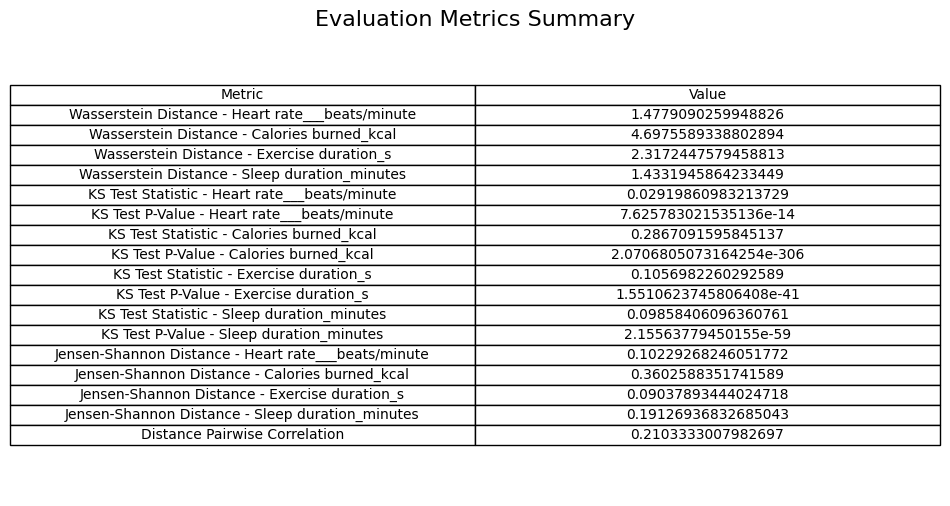

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial import distance
import matplotlib.pyplot as plt

# File path for the original and synthetic data
original_file_path = 'https://raw.githubusercontent.com/FANMISUA/BHI_Track1/refs/heads/main/Code/combined_synthetic_data_with_patient_ids.csv'
synthetic_file_path = 'Synthetic_Combined_Data1.csv'

# Load original data
original_df = pd.read_csv(original_file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})
original_df['Datetime'] = pd.to_datetime(original_df['Datetime'].str.replace('=', '-', regex=False), errors='coerce')

# Load synthetic data
synthetic_df = pd.read_csv(synthetic_file_path, dtype={'Activity_Type': 'str', 'Patient ID': 'str'})
synthetic_df['Datetime'] = pd.to_datetime(synthetic_df['Datetime'], errors='coerce')

# Define columns of interest for evaluation
columns_of_interest = ['Heart rate___beats/minute', 'Calories burned_kcal', 'Exercise duration_s', 'Sleep duration_minutes']

# Initialize a list to hold the results
evaluation_results = []

# Function to remove NaN values and convert exercise duration
def drop_nan_and_convert_exercise(column, is_exercise=False):
    clean_data = column.dropna()
    if is_exercise:
        # Convert exercise duration from seconds to milliseconds (10^-3)
        clean_data = clean_data * 1e-3
    return clean_data

# 1. Wasserstein Distance
for column in columns_of_interest:
    is_exercise = column == 'Exercise duration_s'
    original_clean = drop_nan_and_convert_exercise(original_df[column], is_exercise)
    synthetic_clean = drop_nan_and_convert_exercise(synthetic_df[column], is_exercise)

    if not original_clean.empty and not synthetic_clean.empty:
        wd = wasserstein_distance(original_clean, synthetic_clean)
        evaluation_results.append({'Metric': f'Wasserstein Distance - {column}', 'Value': wd})

# 2. Kolmogorov-Smirnov (KS) Test
for column in columns_of_interest:
    is_exercise = column == 'Exercise duration_s'
    original_clean = drop_nan_and_convert_exercise(original_df[column], is_exercise)
    synthetic_clean = drop_nan_and_convert_exercise(synthetic_df[column], is_exercise)

    if not original_clean.empty and not synthetic_clean.empty:
        ks_stat, ks_p_value = ks_2samp(original_clean, synthetic_clean)
        evaluation_results.append({'Metric': f'KS Test Statistic - {column}', 'Value': ks_stat})
        evaluation_results.append({'Metric': f'KS Test P-Value - {column}', 'Value': ks_p_value})

# 3. Jensen-Shannon Distance
for column in columns_of_interest:
    is_exercise = column == 'Exercise duration_s'
    original_clean = drop_nan_and_convert_exercise(original_df[column], is_exercise)
    synthetic_clean = drop_nan_and_convert_exercise(synthetic_df[column], is_exercise)

    if not original_clean.empty and not synthetic_clean.empty:
        # Create histograms
        p = np.histogram(original_clean, bins=30, density=True)[0]
        q = np.histogram(synthetic_clean, bins=30, density=True)[0]

        # Avoid division by zero
        p = p / np.sum(p) if np.sum(p) > 0 else p
        q = q / np.sum(q) if np.sum(q) > 0 else q

        jsd = distance.jensenshannon(p, q)
        evaluation_results.append({'Metric': f'Jensen-Shannon Distance - {column}', 'Value': jsd})

# 4. Distance Pairwise Correlation
original_corr = original_df[columns_of_interest].corr()
synthetic_corr = synthetic_df[columns_of_interest].corr()
correlation_difference = np.abs(original_corr - synthetic_corr).mean().mean()  # Average of the absolute differences
evaluation_results.append({'Metric': 'Distance Pairwise Correlation', 'Value': correlation_difference})

# Convert the results list to a DataFrame
evaluation_results_df = pd.DataFrame(evaluation_results)

# Output the evaluation results to a CSV file
evaluation_results_df.to_csv('evaluation_metrics_summary.csv', index=False)

# Print results and save as a PNG table
print(evaluation_results_df)

# Create a PNG table from the evaluation results
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=evaluation_results_df.values, colLabels=evaluation_results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Evaluation Metrics Summary', fontsize=16)

# Save the table as a PNG file
plt.savefig('evaluation_metrics_summary_table.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

print("Evaluation metrics summary table saved to 'evaluation_metrics_summary.csv'.")
print("Table image saved to 'evaluation_metrics_summary_table.png'.")
